# Own dataset for predicting resp rate from ECG
### Decided to make a regression model for creating respiratory signal from ECG

In [1]:
import random
import os
import numpy as np
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import physio
from tqdm import tqdm
import neurokit2 as nk
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import interp1d
from scipy.special import softmax, log_softmax
from matplotlib import pyplot as plt
from customLib.preprocess import *
from models.models import LSTM
from customLib.peak_detection import find_mean_avg_r_peak_indices, detect_nk
from customLib.dataset import split_dataset

e:\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = ".\\aidmed_ecgs\\with_resp"

aidmed_ecg_sampling_rate = 250
aidmed_resp_sampling_rate = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 16

kernel_size = 51
padding_amount = (kernel_size - 1) // 2
smoothening_kernel = torch.FloatTensor([[[1/kernel_size for _ in range(kernel_size)]]]).to(device)

### Read ECGs and RESPs from specific path

In [3]:
files = [x for x in os.listdir(root_path) if not os.path.isdir(root_path + "//" + x)]

ecgs = [os.path.join(root_path, x) for x in files[0::4]]
cycles =  [os.path.join(root_path, x) for x in files[1::4]]
resps =  [os.path.join(root_path, x) for x in files[2::4]]
annotations =  [os.path.join(root_path, x) for x in files[3::4]]

assert len(files) == len(ecgs) + len(resps) + len(annotations) + len(cycles)
assert (len(ecgs) + len(resps) + len(annotations) + len(cycles)) % 4 == 0

### Read all ECGs and RESPs

In [4]:
files = []

for dir, subfolders, recordings in os.walk(root_path):
    for file in recordings:
        files.append(os.path.join(dir, file))

ecgs = [x for x in files[0::4]]
cycles =  [x for x in files[1::4]]
resps =  [x for x in files[2::4]]
annotations =  [x for x in files[3::4]]

assert len(files) == len(ecgs) + len(resps) + len(annotations) + len(cycles)
assert (len(ecgs) + len(resps) + len(annotations) + len(cycles)) % 4 == 0

In [5]:
def shift_windows(ecg, resp, annotation, resp_cycle_annotation):
    """
    Function for shifting one of the signals if they happen to have different time stamps

    Args:
    ecg - a 2D array where the second column (index 1) is timestamps, first column (index 0) is ecg values
    resp - a 2D array where the second column (index 1) is timestamps, first column (index 0) is resp values
    annotation - a 1D array of RESP local maxima indices
    resp_cycle_annotation - a 1D array of resp cycle indices
    """
    # Accessing the timestamps correctly from index 1
    ecg_first_timestep = ecg[0, 1]
    ecg_last_timestep = ecg[-1, 1]

    resp_first_timestep = resp[0, 1]
    resp_last_timestep = resp[-1, 1]

    try:
        if ecg_first_timestep != resp_first_timestep:
            raise ValueError("start-mismatch")
        if ecg_last_timestep != resp_last_timestep:
            raise ValueError("end-mismatch")
    except ValueError as e:
        if str(e) == "start-mismatch":
            print("Start mismatch detected.")
            if ecg_first_timestep < resp_first_timestep:
                # Find index where ECG timestamps are >= the first RESP timestamp
                mismatch_idx = np.where(ecg[:, 1] >= resp_first_timestep)[0][0]
                ecg = ecg[mismatch_idx:]  # Remove earlier timestamps in ECG
            else:
                # Find index where RESP timestamps are >= the first ECG timestamp
                mismatch_idx = np.where(resp[:, 1] >= ecg_first_timestep)[0][0]
                resp = resp[mismatch_idx:]  # Remove earlier timestamps in RESP
                annotation = annotation - mismatch_idx  # Shift annotation indices
                annotation = annotation[annotation > 0]  # Keep only valid positive indices
                resp_cycle_annotation = resp_cycle_annotation - mismatch_idx
                resp_cycle_annotation = resp_cycle_annotation[resp_cycle_annotation > 0]
        elif str(e) == "end-mismatch":
            print("End mismatch detected.")
            if ecg_last_timestep < resp_last_timestep:
                # Find index where RESP timestamps are >= the last ECG timestamp
                mismatch_idx = np.where(resp[:, 1] >= ecg_last_timestep)[0][0]
                resp = resp[:mismatch_idx]  # Remove later timestamps in RESP
                annotation = annotation[annotation < mismatch_idx]  # Adjust annotation
                resp_cycle_annotation = resp_cycle_annotation[resp_cycle_annotation < mismatch_idx]
            else:
                # Find index where ECG timestamps are >= the last RESP timestamp
                mismatch_idx = np.where(ecg[:, 1] >= resp_last_timestep)[0][0]
                ecg = ecg[:mismatch_idx]  # Remove later timestamps in ECG
        else:
            raise Exception("An unknown data timestamp mismatch occurred.")
    finally:
        # Ensure resp and ecg are 1D after adjusting
        if len(ecg.shape) > 1:
            ecg = ecg[:, 0]  # Assuming first column has RESP values
        if len(resp.shape) > 1:
            resp = resp[:, 0]  # Assuming first column has ECG values

        #print("ECG shape:", ecg.shape, " Time:", ecg.shape[0] / aidmed_ecg_sampling_rate)
        #print("RESP shape:", resp.shape, " Time:", resp.shape[0] / aidmed_resp_sampling_rate)

    return ecg, resp, annotation, resp_cycle_annotation


In [6]:
def plot_ecg_resp(ecg, resp, annotation=None):
    fig, axs = plt.subplots(nrows=2)

    t_ecg = [x * 1/aidmed_ecg_sampling_rate for x in range(ecg.shape[0])]
    t_resp = [x * 1/aidmed_resp_sampling_rate for x in range(resp.shape[0])]

    ax = axs[0]
    ax.plot(t_ecg, ecg)
    ax.grid()

    ax = axs[1]
    ax.plot(t_resp, resp)
    if annotation:
        ax.plot(annotation * 1/aidmed_resp_sampling_rate, resp[annotation], 'rx')
    ax.grid()

    fig.show()

In [7]:
def prepare_x_y_windows(window_in_seconds, windows_overlap_factor=0.85):
    ecg_target_window_length = window_in_seconds * aidmed_ecg_sampling_rate
    resp_target_window_length = window_in_seconds * aidmed_resp_sampling_rate

    x, y = np.empty((0, ecg_target_window_length)), np.empty((0, resp_target_window_length, 3))

    for i, (ecg, resp, annotation, resp_cycle_annotation) in enumerate(zip(ecgs, resps, annotations, cycles)):
        ecg = np.load(ecg)
        resp = np.load(resp)

        with open(annotation, "rb") as f:
            resp_peak_indices = pickle.load(f)

        with open(resp_cycle_annotation, "rb") as f:
            resp_cycle_indices = pickle.load(f)

        ecg, resp, resp_peak_indices, resp_cycle_indices = shift_windows(ecg, resp, resp_peak_indices, resp_cycle_indices)

        # Create an annotation for the respiratory peaks
        annotation = np.zeros((resp.shape[0]))
        annotation[resp_peak_indices] = 1

        resp_cycle_annotation = np.zeros((resp.shape[0]))
        resp_cycle_annotation[resp_cycle_indices] = 1

        ecg = myConv1D(signal=ecg, kernel_length=5, padding="same")

        # Split signals into windows
        ecg_windows = split_signal(ecg, start=0, window_in_seconds=window_in_seconds, fs=aidmed_ecg_sampling_rate, overlap_factor=windows_overlap_factor, normalize=(True, (-1, 1)), denoise=False)
        resp_windows = split_signal(resp, start=0, window_in_seconds=window_in_seconds, fs=aidmed_resp_sampling_rate, overlap_factor=windows_overlap_factor, normalize=False, denoise=False)  
        annotation_windows = split_signal(annotation, start=0, window_in_seconds=window_in_seconds, fs=aidmed_resp_sampling_rate, overlap_factor=windows_overlap_factor, normalize=False, denoise=False)
        resp_cycle_annotation_windows = split_signal(resp_cycle_annotation, start=0, window_in_seconds=window_in_seconds, fs=aidmed_resp_sampling_rate, overlap_factor=windows_overlap_factor, normalize=False, denoise=False)

        ecg_windows = np.array(ecg_windows)
        resp_windows = np.array(resp_windows)

        annotation_windows = np.array(annotation_windows)
        resp_cycle_annotation_windows = np.array(resp_cycle_annotation_windows)
        full_annotation = np.stack((annotation_windows, resp_cycle_annotation_windows), axis=2)

        for i in range(len(resp_windows)):
            clean_resp = nk.rsp.rsp_clean(resp_windows[i], sampling_rate=50)
            clean_resp = myConv1D(clean_resp, kernel_length=100, padding="same")
            resp_windows[i] = norm_min_max(clean_resp, 0, 1)

        # KLDivLoss and jensen - shannon
        # resp_windows = softmax(resp_windows, axis=-1)
        resp_windows = log_softmax(resp_windows, axis=-1) # jensen-shannon, KLDivLoss normalize to (0,1) -> probability dist
        resp_windows = np.expand_dims(resp_windows, -1)

        resp_and_annotation_windows = np.concatenate((resp_windows, full_annotation), axis=-1)
        
        # Concatenate ECG and respiratory windows to x and y
        x = np.concatenate((x, ecg_windows), axis=0)
        y = np.concatenate((y, np.array(resp_and_annotation_windows)), axis=0)

    return x, y


def filter_windows(x, y, window_in_seconds, resp_peaks=8, mode=""):
    """
    Filters ECG and respiratory signal windows based on the number of respiratory peaks detected 
    within each window.

    Args:
        x (np.ndarray): 
            The input array of ECG signal windows, where each window is represented as a 
            2D array of shape (num_windows, window_length).
        
        y (np.ndarray): 
            The input array of respiratory signal windows, including annotations, with a shape of 
            (num_windows, window_length, 3). The second channel contains binary values indicating 
            the presence of respiratory peaks. The third channels contains breath cycle indices.
        
        window_in_seconds (float): 
            The duration of each window in seconds, used to calculate the maximum allowed respiratory 
            peaks based on the provided peak count threshold.
        
        resp_peaks (int, optional): 
            The maximum number of respiratory peaks allowed per window. Default value is 8.
        
        mode (str, optional): 
            A string that determines the filtering condition:
            - "eq": Only includes windows with an exact match of respiratory peaks.
            - "le": Includes windows with less or equal amount of respiratory peaks.
            - "ge": Includes windows tih more or equal amount of respiratory peaks.
            - Other values - works as "le"

    Returns:
        tuple: 
            - filtered_x (np.ndarray): The filtered ECG windows array, containing only the windows 
              that meet the specified peak count condition.
            - filtered_y (np.ndarray): The filtered respiratory windows array, corresponding to the 
              filtered ECG windows, retaining only the relevant annotations and signals.
    """
    resp_peaks_per_window = np.sum(y[:, :, 1], axis=1)  # Using the second channel for breath peaks
    peaks_count_per_window = int(resp_peaks * window_in_seconds / 60)
    
    if mode == "eq":
        filtered_x = x[resp_peaks_per_window == peaks_count_per_window]
        filtered_y = y[resp_peaks_per_window == peaks_count_per_window]
    elif mode =="le":
        filtered_x = x[resp_peaks_per_window <= peaks_count_per_window]
        filtered_y = y[resp_peaks_per_window <= peaks_count_per_window]
    elif mode == "ge":
        filtered_x = x[resp_peaks_per_window >= peaks_count_per_window]
        filtered_y = y[resp_peaks_per_window >= peaks_count_per_window]
    else:
        filtered_x = x[resp_peaks_per_window <= peaks_count_per_window]
        filtered_y = y[resp_peaks_per_window <= peaks_count_per_window]

    return filtered_x, filtered_y


def breath_histogram(breath_peaks_channel, sampling_rate=50):
    window_length = breath_peaks_channel.shape[1] / sampling_rate

    breaths_per_window = np.round(np.sum(breath_peaks_channel, axis=1) / window_length * 60)

    histogram = dict((int(i), list(breaths_per_window).count(i)) for i in breaths_per_window)

    keys = list(histogram.keys())
    values = list(histogram.values())

    max_value = np.max(values)

    _, ax = plt.subplots()

    bars = ax.bar(keys, values, color='dodgerblue', edgecolor="black")
    ax.bar_label(bars, padding=3)
    ax.set_xticks(keys)
    ax.set_ylim(0, max_value + 40)
    ax.grid(alpha=0.5)

    plt.xlabel('Oddechy w oknie', fontweight="semibold", fontsize=12)
    plt.ylabel('Ilość', fontweight="semibold", fontsize=12)
    plt.title('Histogram okien oddechowych', fontweight="semibold")

    # Display the plot
    plt.show()

    return histogram

In [8]:
x, y = prepare_x_y_windows(window_in_seconds=60)

Start mismatch detected.
End mismatch detected.
Start mismatch detected.
End mismatch detected.
End mismatch detected.
End mismatch detected.
Start mismatch detected.
Start mismatch detected.
End mismatch detected.
Start mismatch detected.
End mismatch detected.


In [9]:
x_all, y_all = filter_windows(x, y, 60, resp_peaks=8, mode="le")

# x_8, y_8 = filter_windows(x, y, 60, resp_peaks=8, mode="eq")

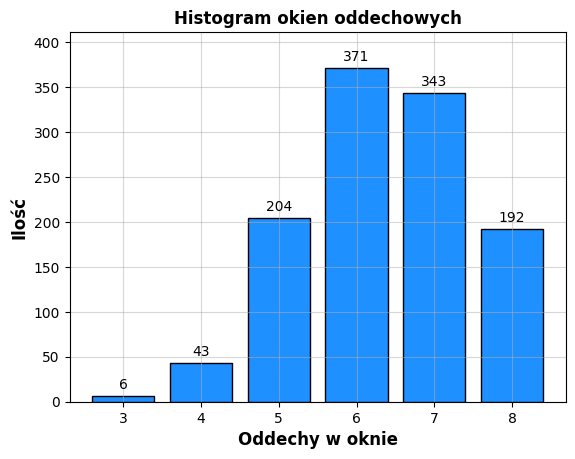

In [10]:
histogram = breath_histogram(y_all[:,:,1])

# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
loss_function_weights = { k: (y_all[:,:,1].shape[0] / (v * len(histogram)) ) for k, v in histogram.items()}

### Append new channel/s to ECG - RR intervals interpolation, RPA interpolation, R Peaks indices as a square wave

In [11]:
def add_new_ecg_channels(x, detector="neurokit"):
    r_peaks_prediction = np.empty((0, x.shape[1]))
    RPA = []

    if detector == "lstm":
        # Prediction using pretrained LSTM
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)

        assert x.dim() == 3

        num_batches = int(np.ceil(x.shape[0] / batch_size))
        model = LSTM(input_dim=1, hidden_size=32, loss_pos_weight=torch.Tensor([17]).to(device))
        model.load_state_dict(torch.load("./checkpoints/lstm/raw_ecgs/lstm_epoch_10_acc_99.88_f1_0.98.pt"))
        model.eval()

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, x.shape[0])

            x_batch = x[start_idx:end_idx]
            x_batch = x_batch.to(device)

            prediction = model(x_batch)
            prediction = prediction.detach().cpu().numpy()

            # vectors of peak probability in a single sample
            r_peaks_batch = (prediction >= 0.5).astype(int)
            r_peaks_batch = r_peaks_batch.reshape((r_peaks_batch.shape[0], r_peaks_batch.shape[1]))
            r_peaks_batch = np.array([find_mean_avg_r_peak_indices(x) for x in r_peaks_batch])

            r_peaks_prediction = np.concatenate((r_peaks_prediction, r_peaks_batch), axis=0)

            x_batch = x_batch.cpu().numpy()
            for example_idx, r_peaks_proba in enumerate(r_peaks_batch):
                r_peaks_indices = np.where(r_peaks_proba == 1)[0]
                ecg_amplitudes = x_batch[example_idx].flatten()[r_peaks_indices]

                assert len(r_peaks_indices) == len(ecg_amplitudes)
                RPA.append(ecg_amplitudes)

        x = x.squeeze(-1).numpy()

    elif detector == "neurokit":
        # Prediction using neurokit
        r_peaks_prediction = np.empty((0, x.shape[1]))

        for ecg in x:
            ecg_peaks_indices = detect_nk(ecg_slice=ecg, fs=aidmed_ecg_sampling_rate)
            ecg_peaks = np.zeros_like(ecg)
            ecg_peaks[ecg_peaks_indices] = 1
            ecg_peaks = np.expand_dims(ecg_peaks, 0)
            r_peaks_prediction = np.concatenate((r_peaks_prediction, ecg_peaks), axis=0)

            ecg_amplitudes = ecg[ecg_peaks_indices]

            assert len(ecg_amplitudes) == len(ecg_peaks_indices)

            RPA.append(ecg[ecg_peaks_indices])
    
    else:
        raise ValueError("Invalid detector. Choose either 'lstm' or 'neurokit'.")

    assert len(RPA) == r_peaks_prediction.shape[0]

    foh_waveform_interpolation = []
    rpa_waveform_interpolation = []

    for prediction, RPA_waveform in zip(r_peaks_prediction, RPA):
        r_peaks_idx = np.where(prediction == 1)[0]
        RRs = np.diff(r_peaks_idx) * 1/aidmed_ecg_sampling_rate * 1000

        if 0 in r_peaks_idx and (len(prediction) - 1) in r_peaks_idx:
            RRs = np.concatenate(([int(np.mean(RRs))], RRs), axis=0)

        if (len(prediction) - 1) in r_peaks_idx:
            RRs = np.concatenate((RRs, [int(np.mean(RRs))]), axis=0)

        if 0 not in r_peaks_idx:
            r_peaks_idx = np.concatenate(([0], r_peaks_idx), axis=0)
            RRs = np.concatenate(([int(np.mean(RRs))], RRs), axis=0)
            RPA_waveform = np.concatenate(([np.mean(RPA_waveform)], RPA_waveform), axis=0)

        if (len(prediction) - 1) not in r_peaks_idx:
            r_peaks_idx = np.concatenate((r_peaks_idx, [len(prediction) - 1]), axis=0)
            RRs = np.concatenate((RRs, [int(np.mean(RRs))], [int(np.mean(RRs))]), axis=0)
            RPA_waveform = np.concatenate((RPA_waveform, [np.mean(RPA_waveform)]), axis=0)

        try:
            assert len(r_peaks_idx) == len(RRs) == len(RPA_waveform)
        except:
            print(len(RRs))
            print(len(RPA_waveform))
            print(len(r_peaks_idx))
   
        foh_rrs = interp1d(r_peaks_idx, RRs, kind="linear")           
        foh_rpa = interp1d(r_peaks_idx, RPA_waveform, kind="linear")            

        t_interpolate = [x for x in range(len(prediction))]

        interpolation_rrs = foh_rrs(t_interpolate)
        interpolation_rpa = foh_rpa(t_interpolate)

        interpolation_rrs = norm_min_max(signal=interpolation_rrs, lower=0, upper=1)
        # interpolation_rpa = norm_min_max(signal=interpolation_rpa, lower=0, upper=1)

        foh_waveform_interpolation.append(interpolation_rrs)
        rpa_waveform_interpolation.append(interpolation_rpa)

    foh_waveform_interpolation = np.array(foh_waveform_interpolation)
    rpa_waveform_interpolation = np.array(rpa_waveform_interpolation)

    assert x.shape == foh_waveform_interpolation.shape == rpa_waveform_interpolation.shape

    x = np.stack((x, foh_waveform_interpolation, rpa_waveform_interpolation), axis=2)
    
    return x

In [12]:
sample = -1

if sample == -1:
   sample = x_all.shape[0] - 2

neurokit_example = add_new_ecg_channels(x_all[sample:sample+1,:], detector="neurokit")
lstm_example = add_new_ecg_channels(x_all[sample:sample+1,:], detector="lstm")
resp_example = y_all[sample]

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\patry\AppData\Local\Temp\ipykernel_19884\459030438.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

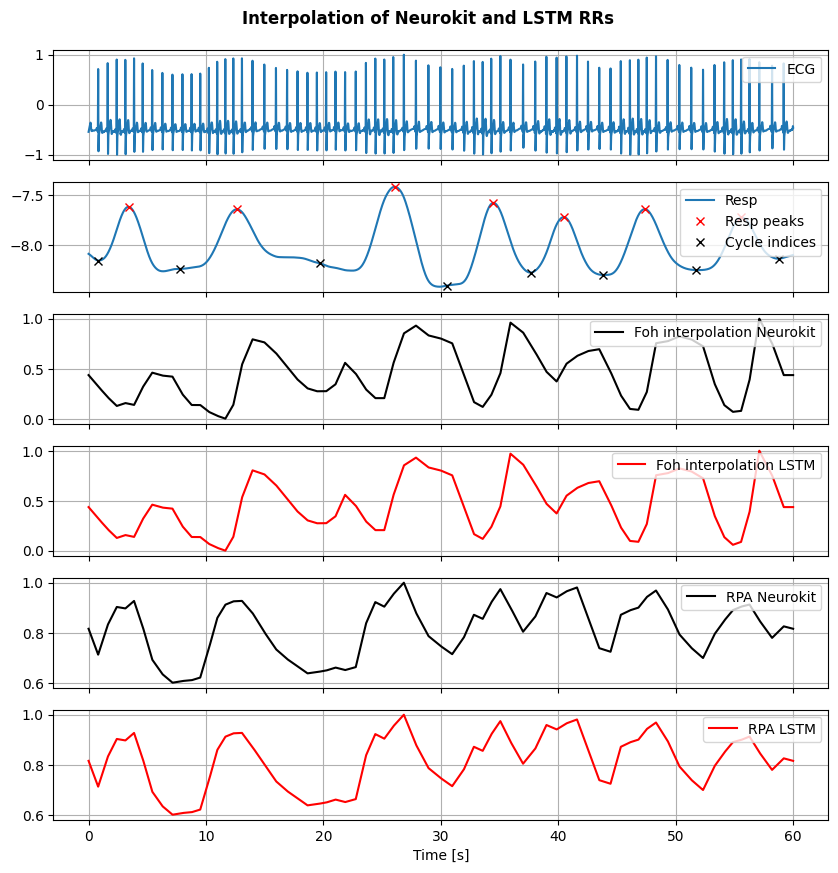

In [13]:
t_interpolate = [x * 1/ aidmed_ecg_sampling_rate for x in range(neurokit_example.shape[1])]
t = [x * 1/ aidmed_ecg_sampling_rate for x in range(neurokit_example.shape[1])]
t_resp = [x * 1/ aidmed_resp_sampling_rate for x in range(resp_example.shape[0])]

resp_peks = np.where(resp_example[:,1] == 1)[0]
resp_cycles_indices = np.where(resp_example[:,2] == 1)[0]

fig, axs = plt.subplots(nrows=6, sharex=True)

ax = axs[0]
ax.grid()
ax.plot(t, neurokit_example[:,:,0].flatten())
# ax.plot(r_peaks_nk * 1/ aidmed_ecg_sampling_rate, x[sample][r_peaks_nk], 'rx')
# ax.plot(r_peaks_lstm * 1/ aidmed_ecg_sampling_rate, x[sample][r_peaks_lstm], 'gx')
ax.legend(["ECG", "NK peaks", "LSTM peaks"], loc='upper right')

ax = axs[1]
ax.plot(t_resp, resp_example[:,0].flatten())
ax.plot(resp_peks * 1/ aidmed_resp_sampling_rate, resp_example[resp_peks,0], 'rx')
ax.plot(resp_cycles_indices * 1/ aidmed_resp_sampling_rate, resp_example[resp_cycles_indices,0], 'x', color="black")
ax.grid()
ax.legend(["Resp", "Resp peaks", "Cycle indices"], loc='upper right')

ax = axs[2]
ax.plot(t_interpolate, neurokit_example[:,:,1].flatten(), 'k-')
ax.grid()
ax.legend(["Foh interpolation Neurokit"], loc='upper right')

ax = axs[3]
ax.plot(t_interpolate, lstm_example[:,:,1].flatten(), 'r-')
ax.grid()
ax.legend(["Foh interpolation LSTM"], loc='upper right')

ax = axs[4]
ax.plot(t_interpolate, neurokit_example[:,:,2].flatten(), 'k-')
ax.grid()
ax.legend(["RPA Neurokit"], loc='upper right')

ax = axs[5]
ax.plot(t_interpolate, lstm_example[:,:,2].flatten(), 'r-')
ax.grid()
ax.legend(["RPA LSTM"], loc='upper right')

plt.xlabel("Time [s]")
fig.suptitle("Interpolation of Neurokit and LSTM RRs", x=0.5,y=0.92, fontweight="semibold")
fig.set_size_inches(10,10)

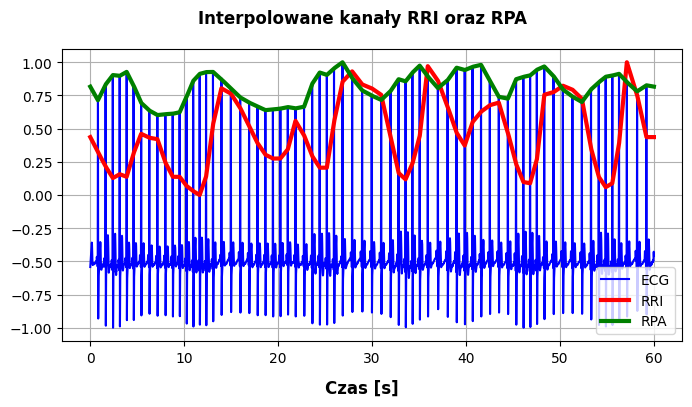

In [14]:
fig, ax = plt.subplots(nrows=1)

plt.subplots_adjust(#left=0.1,
                    bottom=0.15, 
                    #right=0.9, 
                    #top=0.9, 
                    #wspace=0.2, 
                    #hspace=0.3)
)

ecg = lstm_example[:,:,0].flatten()
rri = lstm_example[:,:,1].flatten()
rpa = lstm_example[:,:,2].flatten()

ax.grid()
ax.plot(t, ecg, 'blue')
ax.plot(t, rri, 'red', linewidth=3)
ax.plot(t, rpa, 'green', linewidth=3)
ax.legend(["ECG", "RRI", "RPA"], loc='lower right')

fig.supxlabel("Czas [s]", fontweight="semibold")
fig.suptitle("Interpolowane kanały RRI oraz RPA", fontweight="semibold")
fig.set_size_inches(8,4)

In [18]:
class JensenShannonDivergence(nn.Module):
    def __init__(self):
        super(JensenShannonDivergence, self).__init__()

    def __call__(self, p: torch.Tensor, q: torch.Tensor, log_proba=True) -> torch.Tensor:
        if log_proba:
            # Convert from log-space to probability-space
            p_prob = p.exp()
            q_prob = q.exp()
        else:
            # Inputs are already in probability space
            p_prob = p
            q_prob = q
        
        m_prob = 0.5 * (p_prob + q_prob)
        
        # Convert m back to log-space for KL divergence
        m_log = m_prob.log()
        
        if log_proba:
            # Use p and q directly since they are log-probs
            kl_p_m = F.kl_div(p, m_log, reduction='batchmean', log_target=True)
            kl_q_m = F.kl_div(q, m_log, reduction='batchmean', log_target=True)
        else:
            # Need to take log(p) and log(q) since they are probabilities
            kl_p_m = F.kl_div(p.log(), m_log, reduction='batchmean', log_target=True)
            kl_q_m = F.kl_div(q.log(), m_log, reduction='batchmean', log_target=True)

        return 0.5 * (kl_p_m + kl_q_m)


class NCC(nn.Module):
    def __init__(self, loss_weights=None):
        super(NCC, self).__init__()
        self.loss_weights = loss_weights if loss_weights is not None else {}

    def forward(self, x: torch.Tensor, y: torch.Tensor, peaks_prob_signal: torch.Tensor) -> torch.Tensor:
        """
        Computes the normalized cross-correlation coefficient for input signals.
        The input signal x can be of shape [batch_size, seq_length] or [seq_length].
        The input signal y can be of shape [batch_size, seq_length] or [seq_length].
        The peaks_prob_signal is passed as a separate tensor of shape [batch_size, seq_length].
        Returns a mean value of the cross-correlation coefficients.
        """

        # Reshape x and y if they are 1D (seq_length only) to [1, seq_length]
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Shape becomes [1, seq_length]

        if y.dim() == 1:
            y = y.unsqueeze(0)  # Shape becomes [1, seq_length]

        # Ensure x and y have the same shape
        assert x.shape == y.shape, "X and Y must be of the same shape"
        
        # Calculate weights per batch sample based on peaks_prob_signal
        if self.loss_weights:
            breaths_per_window = torch.sum(peaks_prob_signal, dim=1).long()  # Ensure it's an integer
            weight_per_window = [self.loss_weights.get(int(breath), 1.0) for breath in breaths_per_window]
            weight_per_window = torch.tensor(weight_per_window, device=x.device)
        else:
            weight_per_window = torch.ones(x.shape[0], device=x.device)

        # Compute the mean along the sequence dimension (dim=1)
        x_mean = torch.mean(x, dim=1, keepdim=True)
        y_mean = torch.mean(y, dim=1, keepdim=True)

        # Subtract the mean from the inputs
        x_prime = x - x_mean
        y_prime = y - y_mean

        # Compute the covariance
        covariance = torch.sum(x_prime * y_prime, dim=1)

        # Compute the standard deviations
        std_x = torch.sqrt(torch.sum(x_prime ** 2, dim=1))
        std_y = torch.sqrt(torch.sum(y_prime ** 2, dim=1))

        # Compute the denominator and avoid division by zero
        denominator = std_x * std_y
        r_xy = torch.where(denominator != 0, covariance / denominator, torch.zeros_like(covariance))
        
        # Element-wise multiply with weights
        r_xy = r_xy * weight_per_window

        # Return the mean of the cross-correlation coefficients
        return torch.mean(r_xy)


class WeightedKLDivLoss(nn.Module):
    def __init__(self, loss_weights=None, reduction='batchmean', log_target=True):
        super(WeightedKLDivLoss, self).__init__()
        self.loss_weights = loss_weights if loss_weights is not None else {}
        self.kl_div = nn.KLDivLoss(reduction='none', log_target=log_target)  # Use 'none' to apply custom reduction

    def forward(self, input: torch.Tensor, target: torch.Tensor, peaks_prob_signal: torch.Tensor) -> torch.Tensor:
        """
        Computes weighted KL divergence loss.
        `input` and `target` should have shape [batch_size, *].
        `peaks_prob_signal` is used to calculate `breaths_per_window` and apply sample weights.
        """
        # Compute KL divergence for each element (no reduction)
        kl_loss = self.kl_div(input, target)  # Shape: [batch_size, *]
        
        # Compute mean KL loss per batch sample
        kl_loss_per_batch = kl_loss.sum(dim=1)  # Sum over the feature dimension (shape: [batch_size])

        # Calculate weights per batch sample
        breaths_per_window = torch.sum(peaks_prob_signal, dim=1).long()
        weight_per_window = [self.loss_weights.get(int(breath), 1.0) for breath in breaths_per_window]
        weight_per_window = torch.tensor(weight_per_window, device=input.device)

        # Apply the weights
        weighted_kl_loss = kl_loss_per_batch * weight_per_window

        # Return the mean weighted KL divergence loss
        return torch.mean(weighted_kl_loss)


class WeightedL1Loss(nn.Module):
    def __init__(self, loss_weights=None):
        super(WeightedL1Loss, self).__init__()
        self.loss_weights = loss_weights if loss_weights is not None else {}

    def forward(self, input: torch.Tensor, target: torch.Tensor, peaks_prob_signal: torch.Tensor) -> torch.Tensor:
        """
        Computes weighted L1 loss.
        `input` and `target` should have shape [batch_size, *].
        `peaks_prob_signal` is used to calculate `breaths_per_window` and apply sample weights.
        """
        # Compute L1 loss for each batch sample
        l1_loss = torch.abs(input - target).mean(dim=1)  # Shape: [batch_size]

        # Calculate weights per batch sample
        breaths_per_window = torch.sum(peaks_prob_signal, dim=1).long()
        weight_per_window = [self.loss_weights.get(int(breath), 1.0) for breath in breaths_per_window]
        weight_per_window = torch.tensor(weight_per_window, device=input.device)

        # Apply the weights
        weighted_l1_loss = l1_loss * weight_per_window

        # Return the mean weighted L1 loss across the batch
        return torch.mean(weighted_l1_loss)


class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.counter = 0
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping")
                return True
        return False


class InterpolateLayer(torch.nn.Module):
    def __init__(self, interpolate_ratio=0.2, mode='linear'):
        super(InterpolateLayer, self).__init__()
        self.interpolate_ratio = interpolate_ratio  # Ratio to downsample or upsample
        self.mode = mode
    
    def __call__(self, x):
        _, seq_length, _ = x.shape

        new_seq_length = int(self.interpolate_ratio * seq_length)
        if new_seq_length < 1:
            raise ValueError("Interpolated sequence length must be greater than 1. Got {self.interpolate_ratio} * {seq_length} = {new_seq_length}")

        x = x.permute(0,2,1)
        x = F.interpolate(x, size=new_seq_length, mode=self.mode)
        x = x.permute(0,2,1)

        return x

class RespToECG(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, interpolate_ratio=0.2):
        # redukcja glebokosci
        # dodac warstwy by byl wiekszy lejek

        super(RespToECG, self).__init__()

        self.lstm_1 = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True, dropout=0.3)
        self.layer_norm_1 = nn.LayerNorm(2*hidden_size)

        #self.lstm_2 = torch.nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, bidirectional=True, batch_first=True, dropout=0.3)
        #self.layer_norm_2 = nn.LayerNorm(2*hidden_size)

        self.dense_1 = torch.nn.Linear(in_features=2*hidden_size, out_features=hidden_size)
        
        self.interpolation_layer = InterpolateLayer(interpolate_ratio=interpolate_ratio)
        self.lstm_2 = torch.nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.dense_2 = torch.nn.Linear(in_features=2*hidden_size, out_features=1)
        
        self.to(device)

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x = self.layer_norm_1(x)

        # x, _ = self.lstm_2(x)
        # x = self.layer_norm_2(x)

        x = self.dense_1(x)
        #x = torch.relu(x)

        x = self.interpolation_layer(x)
        x, _ = self.lstm_2(x)
        x = self.dense_2(x)

        x = x.squeeze(-1)

        x = F.log_softmax(x, dim=-1) # KLDivLoss
        # x = F.softmax(x, dim=-1) # jensen-shannon
        return x

In [14]:
class DeviceDataset(Dataset):
  def __init__(self, data, labels):
    super(DeviceDataset, self).__init__()
    self.data = data
    self.labels = labels
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    sample = torch.tensor(self.data[idx], dtype=torch.float32).to(self.device)
    label = torch.tensor(self.labels[idx], dtype=torch.float32).to(self.device)
    return sample, label

In [17]:
x_all_expanded = add_new_ecg_channels(x_all, detector="lstm")
x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(x=x_all_expanded, y=y_all, is_validation_set=True, shuffle=True, split_ratio=0.8)

# additional training - just examples with 8 breaths per minute
#x_8 = add_new_ecg_channels(x_8, detector="neurokit")

train_dataset = DeviceDataset(data=x_train, labels=y_train)
val_dataset = DeviceDataset(data=x_val, labels=y_val)
#train_8_dataset = DeviceDataset(data=x_8, labels=y_8)
test_dataset = DeviceDataset(data=x_test, labels=y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
#train_8_loader = DataLoader(dataset=train_8_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\patry\AppData\Local\Temp\ipykernel_23004\459030438.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

Total X: 1159


In [23]:
def find_resp_maxima(y, sampling_rate=50):
    try:
        y = norm_min_max(y, -1, 1)
        resp_peaks = nk.rsp_findpeaks(y, sampling_rate=sampling_rate)['RSP_Peaks']
        return resp_peaks
    except:
        return np.empty((0,))

def calculate_peak_misalignment(y_true, y_pred, sampling_rate=50):
    """
    Function for calculating the sum of peak misalignment for batch sequences.
    The pred local maximas are calculated using y_true vector.
    y_true is a binary matrix of shape (batch_size, seq_length) where 1 indicates a local maxima.
    y_pred is a predicted matrix of shape (batch_size, seq_length) with predicted values.
    Threshold is the number of samples around a true maxima to search for a predicted maxima.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    batch_size, _ = y_true.shape
    
    total_misalignment_sum = 0.0
    total_target_resp_peaks = 0
    total_pred_resp_peaks = 0

    for batch_idx in range(batch_size):
        y_i = y_true[batch_idx]
        y_pred_i = y_pred[batch_idx]

        target_resp_peaks = find_resp_maxima(y_i, sampling_rate=sampling_rate)
        pred_resp_peaks = find_resp_maxima(y_pred_i, sampling_rate=sampling_rate)

        if len(target_resp_peaks) == 0:
            continue

        total_target_resp_peaks += len(target_resp_peaks)
        total_pred_resp_peaks += len(pred_resp_peaks)

        if len(target_resp_peaks) == len(pred_resp_peaks):
            total_misalignment_sum += np.sum(np.abs(total_target_resp_peaks - total_pred_resp_peaks))
        else:
            total_misalignment_sum += 0

    return total_misalignment_sum, total_target_resp_peaks, total_pred_resp_peaks


def get_resp_cycles(y, cycle_indices):
    """
    Function for returning subtensors (cycles of respiration) from y.
    y -> tensor of shape [batch_size x seq_length] (contains only respiration signal).
    cycle_indices -> tensor of shape [batch_size x seq_length] (contains only cycle indices).
    """
    cycles = []

    for batch_idx in range(y.shape[0]):
        cycle_indices_i = cycle_indices[batch_idx, :]
        cycle_indices_i = torch.where(cycle_indices_i == 1)[0]

        # No cycles found
        if cycle_indices_i.numel() == 0:
            continue  

        for (start_i, end_i) in zip(cycle_indices_i[0::2], cycle_indices_i[1::2]):
            cycle = y[batch_idx, start_i:end_i]
            cycles.append(cycle)

    return cycles


def calculate_cycle_alignment(y_true, y_pred):
    """
    Function for calculating the cycle alignment for batch sequences.
    y_pred is a predicted matrix of shape (batch_size, seq_length) with predicted values.
    y_true is a matrix of shape (batch_size, seq_length, channels) where the last channel stores cycle indices.
    """
    # Extract cycle indices and true respiration values
    cycle_indices = y_true[:, :, 2]  # (batch_size, seq_length) - last channel stores cycle indices
    true_resp_values = y_true[:, :, 0]  # True respiration signal (first channel)

    true_cycles = get_resp_cycles(true_resp_values, cycle_indices)
    pred_cycles = get_resp_cycles(y_pred, cycle_indices)

    criterion = NCC()

    metric_value = 0.0
    cycle_count = 0

    for true_cycle, pred_cycle in zip(true_cycles, pred_cycles):
        # Ensure the predicted cycle and true cycle have matching lengths
        if true_cycle.shape == pred_cycle.shape:
            metric_value += criterion(true_cycle, pred_cycle).item()
            cycle_count += 1

    return metric_value / cycle_count if cycle_count > 0 else 0.0


def get_cycle_indices(y: np.array, sampling_rate=50) -> list[list[int]]:
    if y.ndim == 1:
        y = np.reshape(y, (1, len(y)))

    all_mean_index = []

    for batch_idx in range(y.shape[0]):
        try:
            resp = norm_min_max(y[batch_idx], -1, 1)
            _, resp_cycles = physio.compute_respiration(resp, srate=sampling_rate, parameter_preset='human_airflow')
            inspi_index = resp_cycles['inspi_index'].values
            expi_index = resp_cycles['expi_index'].values
            mean_index = ((inspi_index + expi_index) / 2)
            all_mean_index.append(np.array(mean_index, dtype=int))
        except:
            all_mean_index.append(np.array([]))
        
    return all_mean_index


def calculate_cycle_time_deviation(y_true, y_pred, sampling_rate):
    time_deviation = 0.0
    cycle_count = 0

    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    # cycle_indices = y_true[:, :, 2]  # (batch_size, seq_length) - last channel stores cycle indices
    true_resp_values = y_true[:, :, 0]  # True respiration signal (first channel)

    true_cycle_indices = get_cycle_indices(true_resp_values)
    pred_cycle_indices = get_cycle_indices(y_pred)

    for true_indices, pred_indices in zip(true_cycle_indices, pred_cycle_indices):
        if len(true_indices) == len(pred_indices) and len(true_indices) != 0:
            time_deviation += np.sum(np.abs(np.array(true_indices) - np.array(pred_indices)))
            cycle_count += len(true_indices) - 1

    if cycle_count > 0:
        return time_deviation / cycle_count / sampling_rate, cycle_count
    else:
        return 0, 0

In [21]:
def plot_result(inputs, targets, outputs, title=""):
    rand_idx = random.randint(0, inputs.shape[0] - 1)
    input = inputs[rand_idx].detach().cpu().numpy()
    ecg = input[:, 0]
    rrs = input[:, 1]
    rpa = input[:, 2]

    target = targets[rand_idx][:,0]
    target = target.detach().cpu().numpy()

    label_peaks = targets[rand_idx][:,1]
    label_peaks = label_peaks.detach().cpu().numpy()

    resp_regression = outputs[rand_idx]
    resp_regression = resp_regression.detach().cpu().numpy()
    # resp_regression = myConv1D(resp_regression, kernel_length=50, padding="same")

    # rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=1000)
    # ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=aidmed_ecg_sampling_rate, desired_length=len(ecg))
    # edr = nk.ecg_rsp(ecg_rate, sampling_rate=aidmed_ecg_sampling_rate)
    # edr = resample_signal(signal=edr, num_samples=len(target))
    # edr = norm_min_max(edr, lower=0, upper=1)

    # resp_regression_maximas = find_predicted_maxima(torch.tensor(resp_peaks), torch.tensor(resp_regression), resp_regression.shape[0], neighbourhood=200)
    # resp_regression_maximas_proba = np.zeros_like(resp_regression)
    # resp_regression_maximas_proba[np.array(resp_regression_maximas)] = 1

    #target_maximas = find_resp_maxima(y=target, sampling_rate=aidmed_resp_sampling_rate)
    target_maximas = targets[rand_idx][:,1].cpu().numpy().astype(int)
    target_maximas = np.where(target_maximas == 1)[0]
    pred_maximas = find_resp_maxima(y=resp_regression, sampling_rate=aidmed_resp_sampling_rate)

    target_cycle_indices = get_cycle_indices(target, aidmed_resp_sampling_rate)[0]
    pred_cycle_indices = get_cycle_indices(resp_regression, aidmed_resp_sampling_rate)[0]

    resp_peaks = np.zeros_like(resp_regression)
    resp_peaks[target_maximas] = 1

    pred_peaks = np.zeros_like(resp_regression)
    if len(pred_maximas) > 0:
        pred_peaks[pred_maximas] = 1

    fig, axs = plt.subplots(nrows=2, sharex=True)

    t_ecg = np.array([x * 1/aidmed_ecg_sampling_rate for x in range(len(ecg))])
    t_resp = np.array([x * 1/aidmed_resp_sampling_rate for x in range(len(target))])
    
    
    ax = axs[0]
    ax.plot(t_ecg, ecg.flatten(), color="#1f77b4")
    ax.plot(t_ecg, rrs.flatten(), color="#ff2800", linewidth=2.5)
    ax.plot(t_ecg, rpa.flatten(), color="#2ca02c", linewidth=2.5)
    ax.grid()
    ax.legend(["ECG", "RRI", "RPA"])

    ax = axs[1]
    ax.plot(t_resp, target.flatten(), 'red')
    ax.plot(t_resp, resp_regression.flatten(), 'blue')
    if len(target_cycle_indices) > 0:
        ax.plot(t_resp[target_cycle_indices], target.flatten()[target_cycle_indices], 'o', color="black")
    
    if len(pred_cycle_indices) > 0:
        ax.plot(t_resp[pred_cycle_indices], resp_regression.flatten()[pred_cycle_indices], 'o', color="green")

    # ax.plot(t_resp, edr.flatten(), 'b-')
    ax.legend(["Oddech", "Regresja", "Cykl oddechowy", "Cykl oddechowy regresji"])
    ax.grid()

    # ax = axs[2]
    # ax.plot(t_resp, resp_peaks.flatten(), 'red')
    # ax.plot(t_resp, pred_peaks.flatten(), 'blue')
    # #ax.plot(t_resp, edr.flatten(), 'b-')
    # ax.legend(["Peaks", "Pred maximas"])
    # ax.grid()

    window_in_seconds = len(label_peaks) / aidmed_resp_sampling_rate
    breaths_per_minute = np.sum(label_peaks) / window_in_seconds * 60

    if title != "":
        title += f" , BPM - {breaths_per_minute}"
    else:
        title = f"BPM - {breaths_per_minute}"

    fig.suptitle(title, fontweight="semibold")
    fig.set_size_inches(8,5)
    fig.supxlabel("Czas [s]", fontweight="semibold")
    plt.show()


def validate(epoch, model, val_loader, alfa=0.5):
    model.eval()  # Set the model to evaluation mode
    #criterion_1 = WeightedL1Loss(loss_weights=loss_function_weights)
    # NCC(), nn.KLDivLoss(reduction="batchmean") (not really usefull here, when comparing a period of 60 sec breath)
    # criterion_2 = nn.CosineEmbeddingLoss()
    #criterion_2 = WeightedKLDivLoss(loss_weights=loss_function_weights, reduction="batchmean", log_target=True)
    ncc_criterion = NCC()
    #jsd_criterion = JensenShannonDivergence()

    criterion_1 = nn.L1Loss()
    criterion_2 = nn.KLDivLoss(reduction="batchmean", log_target=True)

    epoch_val_loss = 0.0
    epoch_kldiv_loss = 0.0
    epoch_l1_loss = 0.0

    ncc_metric_value = 0.0
    #jsd_metric_value = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # Forward pass
            outputs = model(inputs)

            # if epoch > 7:
            #     outputs = outputs.unsqueeze(-1)
            #     outputs = outputs.permute((0,2,1))
            #     outputs = F.conv1d(outputs, weight=smoothening_kernel)
            #     outputs = F.pad(outputs, (padding_amount, padding_amount), mode='replicate')
            #     outputs = outputs.permute((0,2,1))
            #     outputs = outputs.squeeze(-1)

            # Compute the loss
            loss_1 = criterion_1(outputs, targets[:,:,0])
            loss_2 = criterion_2(outputs, targets[:,:,0])

            ncc_metric_value += ncc_criterion(outputs, targets[:,:,0], targets[:,:,1]).item()
            #jsd_metric_value += jsd_criterion(outputs, targets[:,:,0], log_proba=True).item()

            # similarity_tensor = torch.tensor([1 for _ in range(targets.shape[0])]).to(device)
            # loss_2 = criterion_2(outputs, targets[:,:,0], similarity_tensor)

            # loss = (1-alfa) * loss_1 + alfa * (1 - loss_2) # NCE

            loss = (1-alfa) * loss_1 + alfa * loss_2 # cosine, KLDivLoss

            # loss = (1-alfa) * loss_1 + alfa * jensen_shannon_divergence(outputs, targets[:,:,0])

            epoch_l1_loss += loss_1.item()
            epoch_kldiv_loss += loss_2.item()
            epoch_val_loss += loss.item()
            # a, b, c = calculate_peak_misalignment(targets[:,:,1], outputs)

            # if epoch > 7:
            #     a, b, c = calculate_peak_misalignment(targets[:,:,0], outputs)
            #     peak_misalignment += a
            #     total_target_resp_peaks += b
            #     total_pred_resp_peaks += c
            #     d, e = calculate_cycle_time_deviation(targets, outputs, 50)
            #     cycle_time_deviation += d
            #     matching_cycles += e

            if batch_idx == len(val_loader) - 1:
                plot_result(inputs, targets, outputs, title=f"Epoka {epoch + 1} - walidacja")

    return epoch_val_loss / len(val_loader), epoch_l1_loss / len(val_loader), epoch_kldiv_loss / len(val_loader), ncc_metric_value / len(val_loader)#, jsd_metric_value / len(val_loader)

def train(model, train_loader, val_loader, epochs=20, learning_rate=0.001, alfa=0.2):
    #criterion_1 = WeightedL1Loss(loss_weights=loss_function_weights)
    # NCC(), nn.KLDivLoss(reduction="batchmean")
    # criterion_2 = nn.CosineEmbeddingLoss()
    #criterion_2 = WeightedKLDivLoss(loss_weights=loss_function_weights, reduction="batchmean", log_target=True)

    criterion_1 = nn.L1Loss()
    criterion_2 = nn.KLDivLoss(reduction="batchmean", log_target=True)

    ncc_criterion = NCC()
    #jsd_criterion = JensenShannonDivergence()

    early_stopper = EarlyStopper(patience=3, min_delta=1e-5)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
    torch.cuda.empty_cache()

    metrics = {
        "train": {
            "loss": {
                "L1": [],
                "KLDivLoss": [],
                "sum": []
            } , 
            "NCC": []
        } , 
        "val": {
            "loss": {
                "L1": [],
                "KLDivLoss": [],
                "sum": []
            } , 
            "NCC": []
        }
    }

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_kldiv_loss = 0.0
        epoch_l1_loss = 0.0
        ncc_metric_value = 0.0
        #jsd_metric_value = 0.0

        for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()

            outputs = model(inputs)

            # if epoch > 7:
            #     outputs = outputs.unsqueeze(-1)
            #     outputs = outputs.permute((0,2,1))
            #     outputs = F.conv1d(outputs, weight=smoothening_kernel)
            #     outputs = F.pad(outputs, (padding_amount, padding_amount), mode='replicate')
            #     outputs = outputs.permute((0,2,1))
            #     outputs = outputs.squeeze(-1)

            loss_1 = criterion_1(outputs, targets[:,:,0])
            loss_2 = criterion_2(outputs, targets[:,:,0])

            ncc_metric_value += ncc_criterion(outputs, targets[:,:,0], targets[:,:,1]).item()
            #jsd_metric_value += jsd_criterion(outputs, targets[:,:,0], log_proba=True).item()

            # similarity_tensor = torch.tensor([1 for _ in range(targets.shape[0])]).to(device)
            # loss_2 = criterion_2(outputs, targets[:,:,0], similarity_tensor)

            # loss = (1-alfa) * loss_1 + alfa * (1 - loss_2) # NCE
            loss = (1 - alfa) * loss_1 + alfa * loss_2 # cosine, KLDivLoss
            

            # loss = (1-alfa) * loss_1 + alfa * jensen_shannon_divergence(outputs, targets[:,:,0])

            loss.backward()
            optimizer.step()

            if batch_idx == len(train_loader) - 1:
                plot_result(inputs, targets, outputs, title=f"Epoka {epoch + 1} - trening")
            
            epoch_l1_loss += loss_1.item()
            epoch_kldiv_loss += loss_2.item()
            epoch_train_loss += loss.item()

            # a, b, c = calculate_peak_misalignment(targets[:,:,1], outputs)

            # if epoch > 7:
            #     a, b, c = calculate_peak_misalignment(targets[:,:,0], outputs)
            #     peak_misalignment += a
            #     total_target_resp_peaks += b
            #     total_pred_resp_peaks += c
            #     d, e = calculate_cycle_time_deviation(targets, outputs, 50)
            #     cycle_time_deviation += d
            #     train_matching_cycles += e

            # cycle_alignment = calculate_cycle_alignment(targets, outputs)

        scheduler.step()
        
        avg_val_loss, avg_l1_val_loss, avg_kldiv_val_loss, val_ncc = validate(epoch, model, val_loader, alfa=alfa)

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_kldiv_train_loss = epoch_kldiv_loss / len(train_loader)
        avg_l1_train_loss = epoch_l1_loss / len(train_loader)

        train_ncc = ncc_metric_value / len(train_loader)
        #train_jsd = jsd_metric_value / len(train_loader)

        metrics["train"]["loss"]["L1"].append(avg_l1_train_loss)
        metrics["train"]["loss"]["KLDivLoss"].append(avg_kldiv_train_loss)
        metrics["train"]["loss"]["sum"].append(avg_train_loss)
        metrics["train"]["NCC"].append(train_ncc)

        metrics["val"]["loss"]["L1"].append(avg_l1_val_loss)
        metrics["val"]["loss"]["KLDivLoss"].append(avg_kldiv_val_loss)
        metrics["val"]["loss"]["sum"].append(avg_val_loss)
        metrics["val"]["NCC"].append(val_ncc)

        print(f'Epoch [{epoch+1}/{epochs}], LR: {scheduler.get_last_lr()}')
        print(f"Avg train loss: {avg_train_loss:<8.6f}  |  Avg validation loss: {avg_val_loss:<8.6f}\n"
              f"Train NCC: {train_ncc:<6.4f} | Val NCC: {val_ncc:<6.4f}\n"
              #f"Train JSD: {train_jsd:<6.4f} | Val JSD: {val_jsd:<6.4f}\n"
              )
            #   f"Train peak misalignment: {peak_misalignment:<6.4f} | Val peak misalignment: {val_peak_misalignment:<6.4f}\n"
            #   f"L1 Train peak detected ratio: {train_peak_detected:<6.4f} | L1 Val peak detected ratio: {val_peak_detected:<6.4f}\n"
            #   #f"Train avg cycle alignment: {cycle_alignment:<6.4f}"
            #   f"Train cycle time deviation: {train_cycle_time_deviation:<6.4f} | Val cycle time deviation: {val_cycle_time_deviation:<6.4f}\n"
            #   f"Train matching cycles count: {train_matching_cycles:<6} | Val matching cycles count: {val_matching_cycles:<6}"
            #   )

        if early_stopper(avg_val_loss):
            break
    
    return model, metrics

In [20]:
model = RespToECG(input_size=3, interpolate_ratio=(aidmed_resp_sampling_rate / aidmed_ecg_sampling_rate))

 98%|█████████▊| 57/58 [00:08<00:00,  7.55it/s]

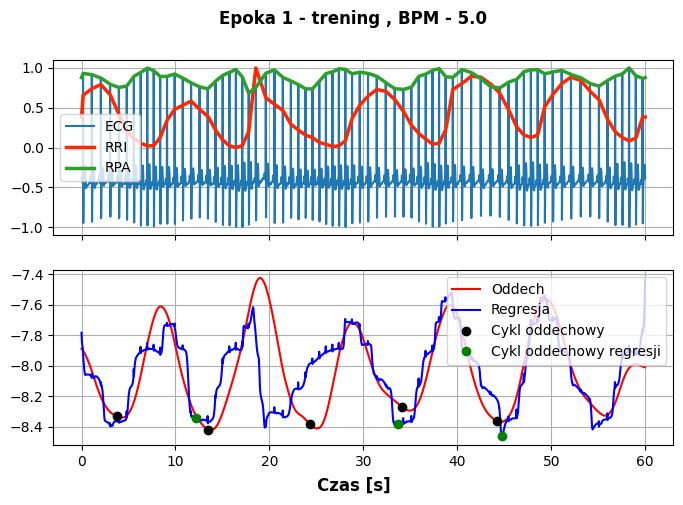

100%|██████████| 58/58 [00:09<00:00,  6.40it/s]


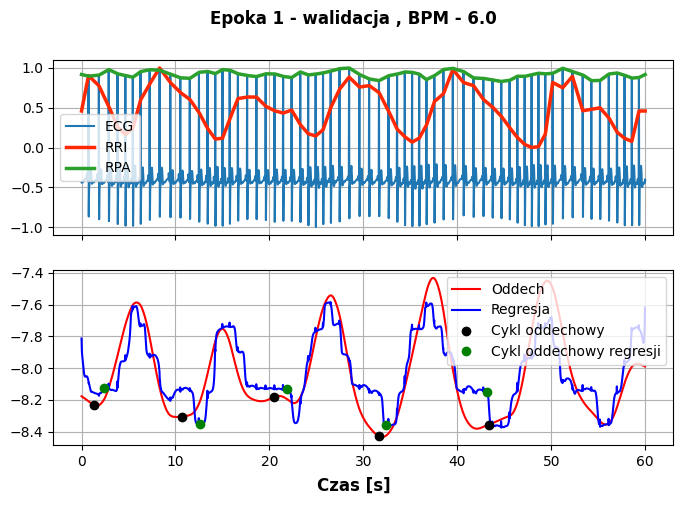

Epoch [1/30], LR: [0.001]
Avg train loss: 0.045214  |  Avg validation loss: 0.029809
Train NCC: 0.5012 | Val NCC: 0.7625



 98%|█████████▊| 57/58 [00:07<00:00,  7.62it/s]

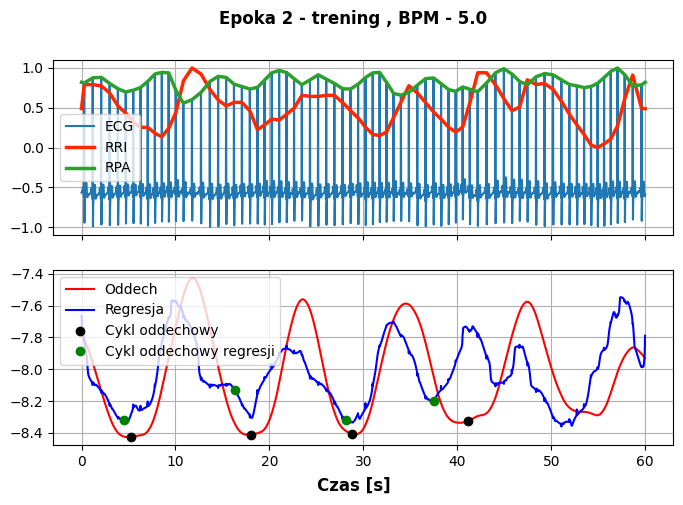

100%|██████████| 58/58 [00:08<00:00,  7.14it/s]


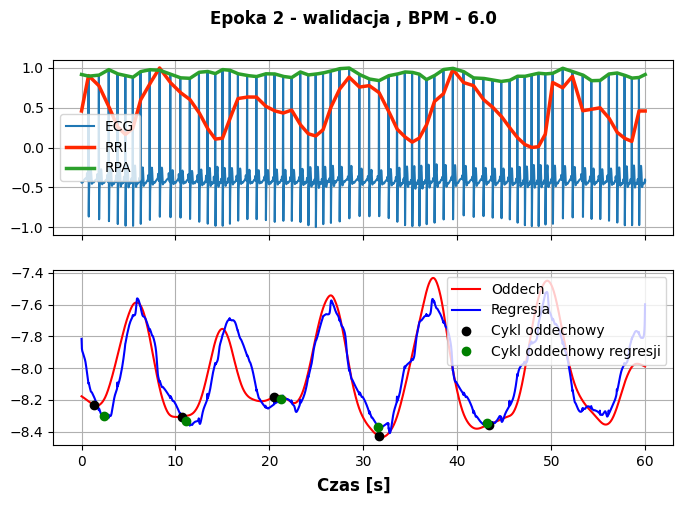

Epoch [2/30], LR: [0.001]
Avg train loss: 0.028954  |  Avg validation loss: 0.024391
Train NCC: 0.7665 | Val NCC: 0.8216



 98%|█████████▊| 57/58 [00:07<00:00,  7.58it/s]

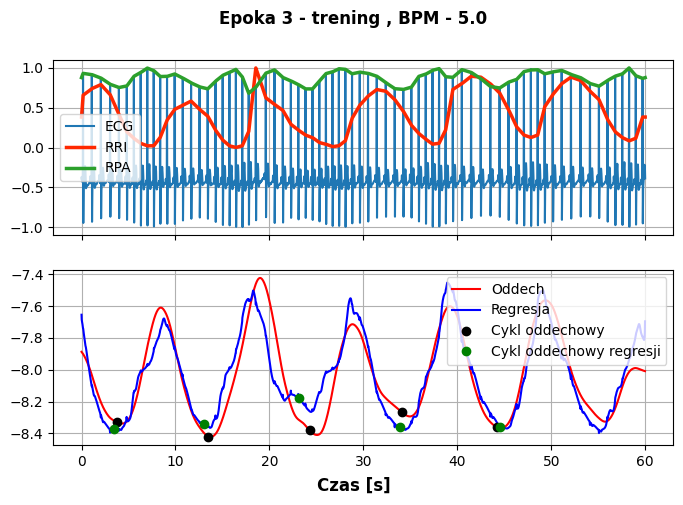

100%|██████████| 58/58 [00:08<00:00,  7.11it/s]


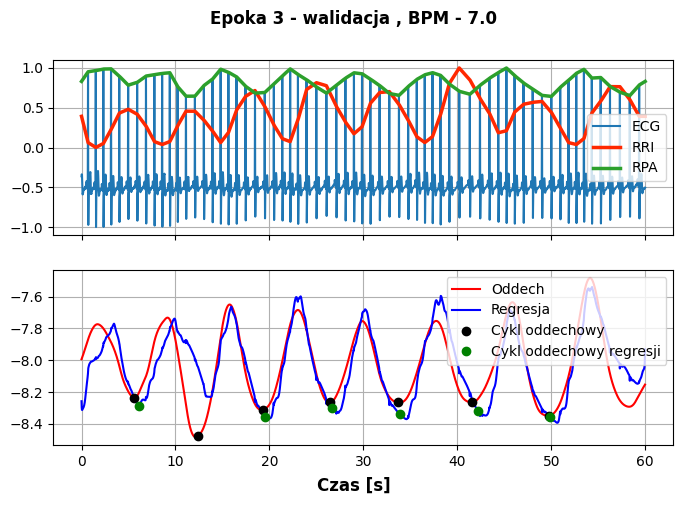

Epoch [3/30], LR: [0.001]
Avg train loss: 0.022718  |  Avg validation loss: 0.019037
Train NCC: 0.8341 | Val NCC: 0.8743



 98%|█████████▊| 57/58 [00:07<00:00,  7.53it/s]

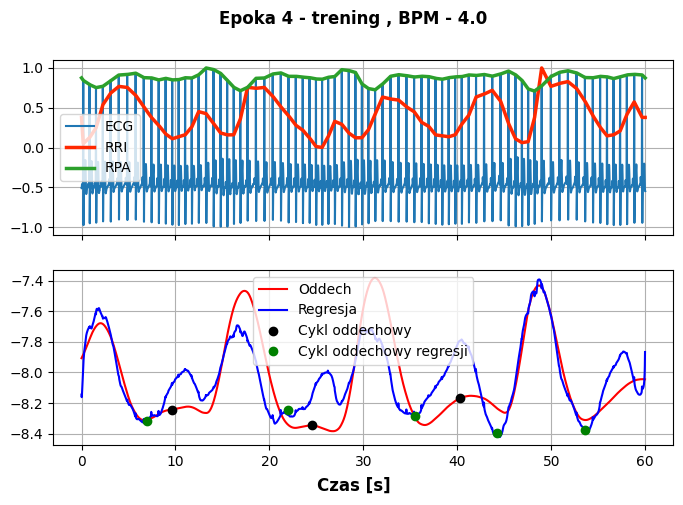

100%|██████████| 58/58 [00:08<00:00,  7.18it/s]


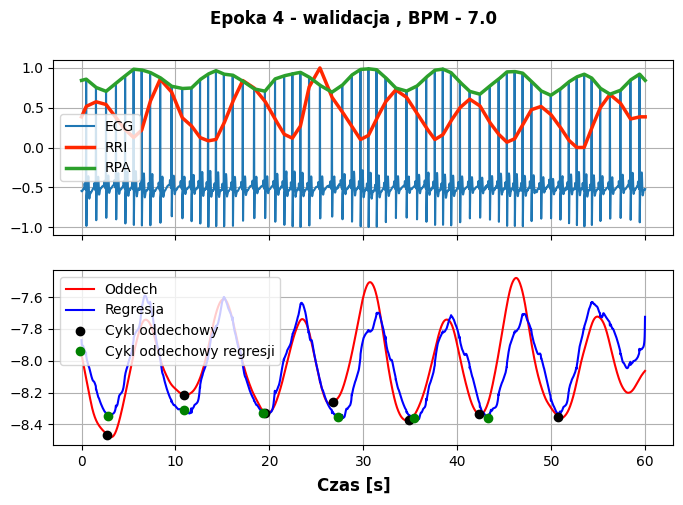

Epoch [4/30], LR: [0.001]
Avg train loss: 0.019568  |  Avg validation loss: 0.017221
Train NCC: 0.8653 | Val NCC: 0.8920



 98%|█████████▊| 57/58 [00:07<00:00,  7.56it/s]

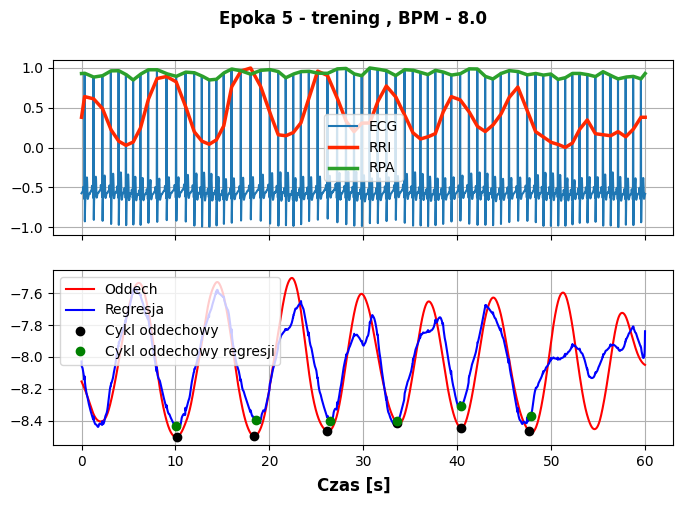

100%|██████████| 58/58 [00:08<00:00,  7.15it/s]


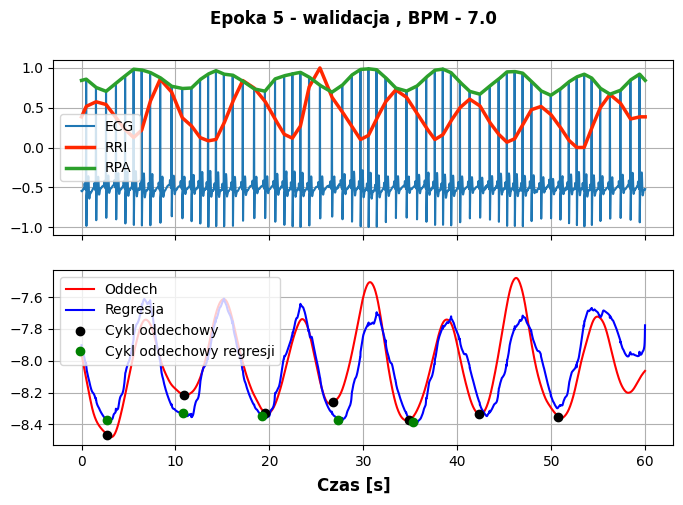

Epoch [5/30], LR: [0.001]
Avg train loss: 0.018139  |  Avg validation loss: 0.016342
Train NCC: 0.8769 | Val NCC: 0.8988



 98%|█████████▊| 57/58 [00:07<00:00,  7.64it/s]

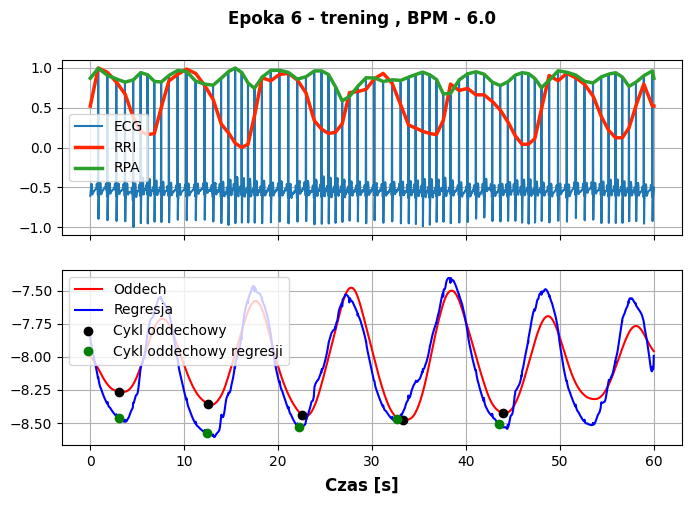

100%|██████████| 58/58 [00:08<00:00,  7.03it/s]


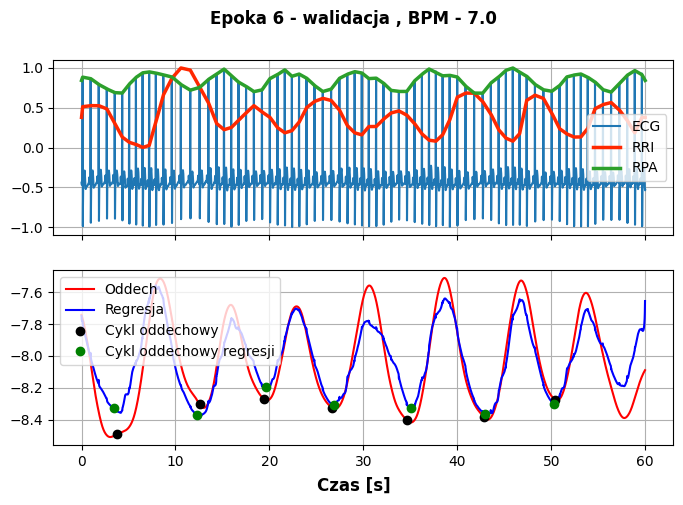

Epoch [6/30], LR: [0.001]
Avg train loss: 0.017683  |  Avg validation loss: 0.016013
Train NCC: 0.8812 | Val NCC: 0.9011



 98%|█████████▊| 57/58 [00:07<00:00,  6.94it/s]

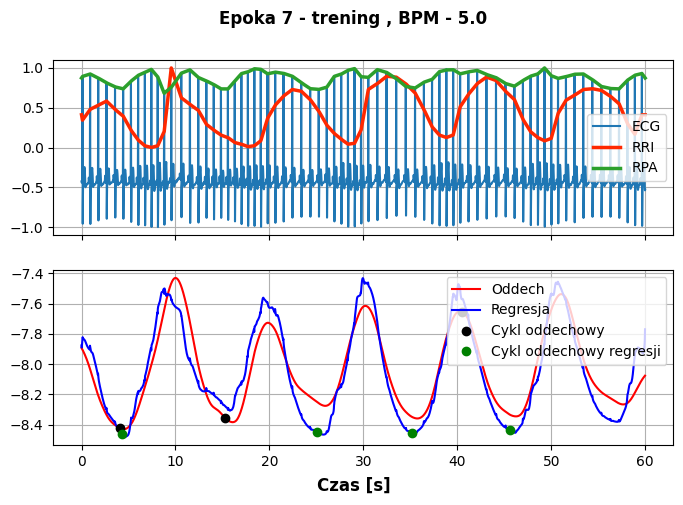

100%|██████████| 58/58 [00:08<00:00,  7.08it/s]


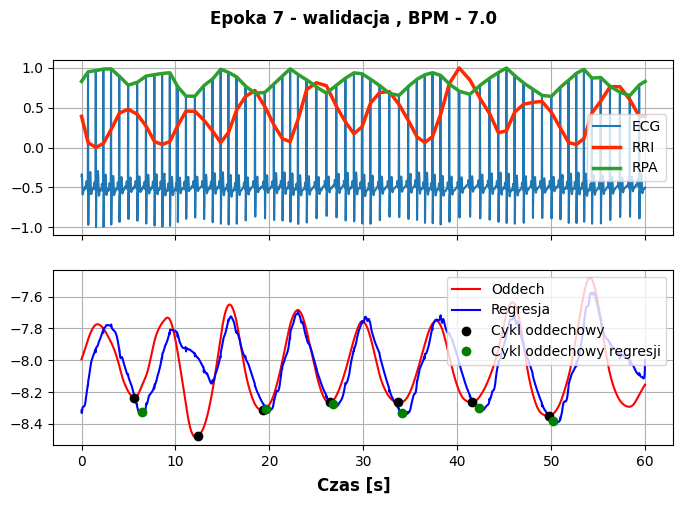

Epoch [7/30], LR: [0.001]
Avg train loss: 0.017181  |  Avg validation loss: 0.015695
Train NCC: 0.8866 | Val NCC: 0.9030



 98%|█████████▊| 57/58 [00:07<00:00,  7.76it/s]

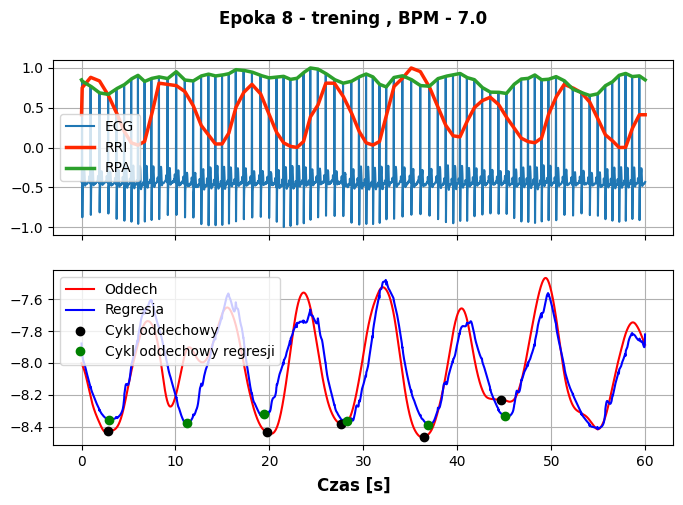

100%|██████████| 58/58 [00:07<00:00,  7.36it/s]


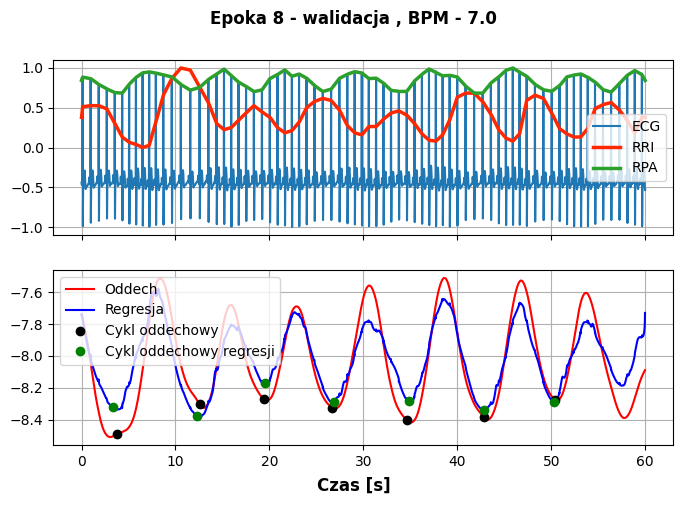

Epoch [8/30], LR: [0.001]
Avg train loss: 0.017000  |  Avg validation loss: 0.015512
Train NCC: 0.8882 | Val NCC: 0.9040



 98%|█████████▊| 57/58 [00:07<00:00,  7.78it/s]

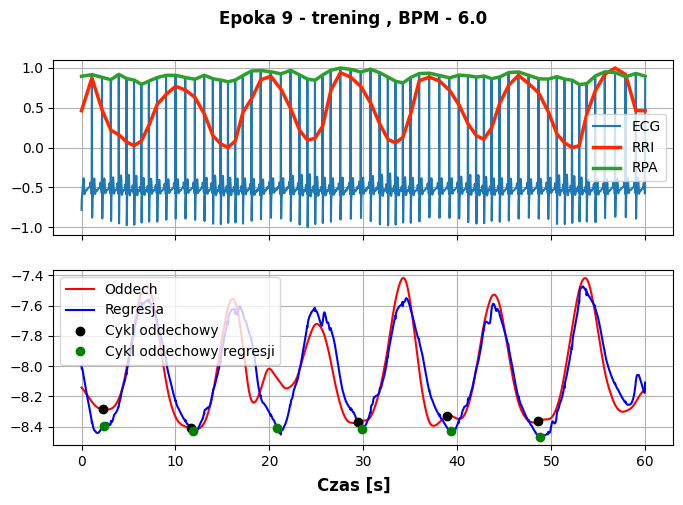

100%|██████████| 58/58 [00:07<00:00,  7.40it/s]


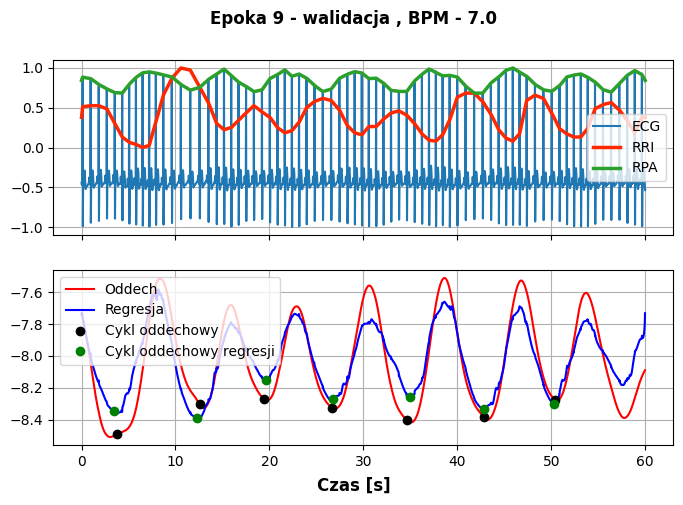

Epoch [9/30], LR: [0.001]
Avg train loss: 0.016521  |  Avg validation loss: 0.015397
Train NCC: 0.8924 | Val NCC: 0.9061



 98%|█████████▊| 57/58 [00:07<00:00,  7.70it/s]

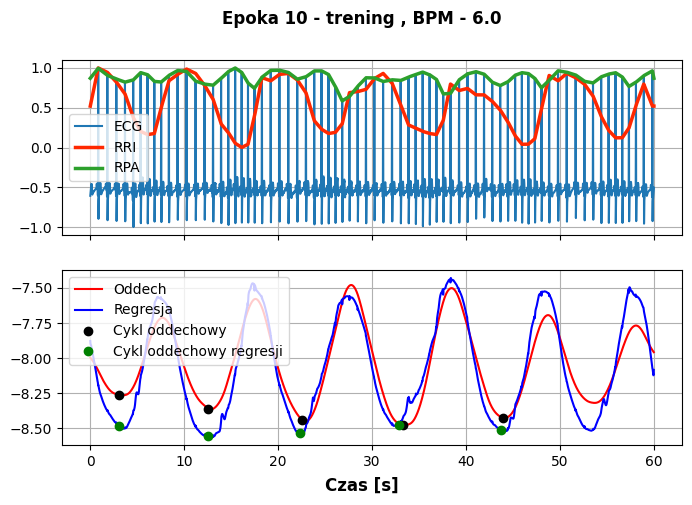

100%|██████████| 58/58 [00:07<00:00,  7.34it/s]


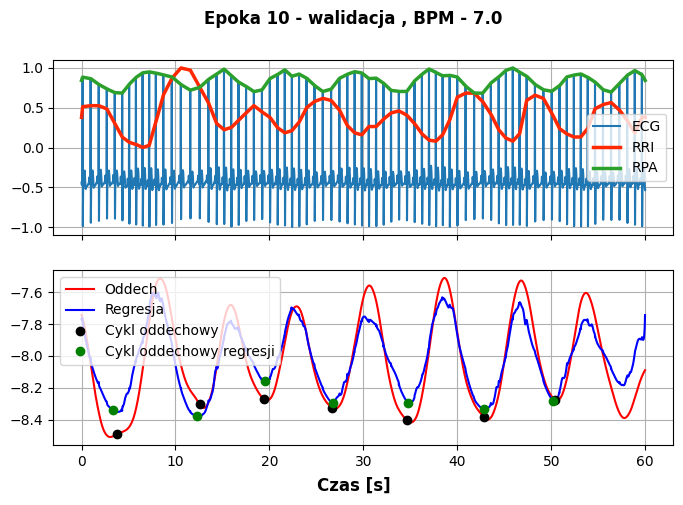

Epoch [10/30], LR: [0.001]
Avg train loss: 0.016170  |  Avg validation loss: 0.015001
Train NCC: 0.8959 | Val NCC: 0.9088



 98%|█████████▊| 57/58 [00:07<00:00,  7.55it/s]

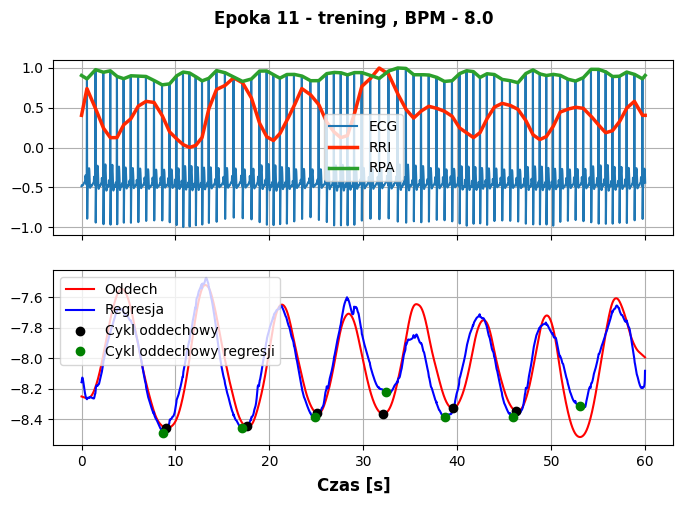

100%|██████████| 58/58 [00:08<00:00,  7.16it/s]


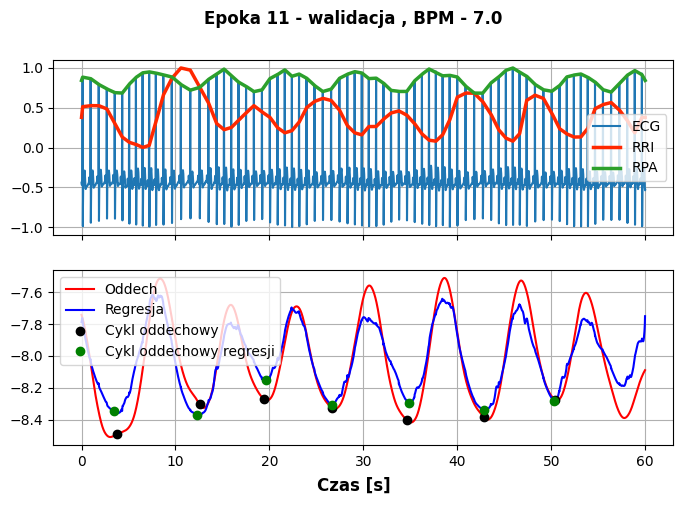

Epoch [11/30], LR: [0.001]
Avg train loss: 0.015909  |  Avg validation loss: 0.014701
Train NCC: 0.8983 | Val NCC: 0.9111



 98%|█████████▊| 57/58 [00:07<00:00,  6.55it/s]

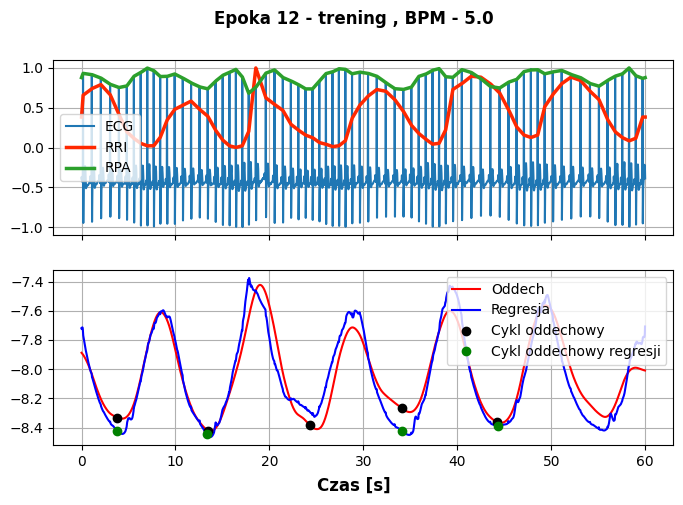

100%|██████████| 58/58 [00:08<00:00,  6.79it/s]


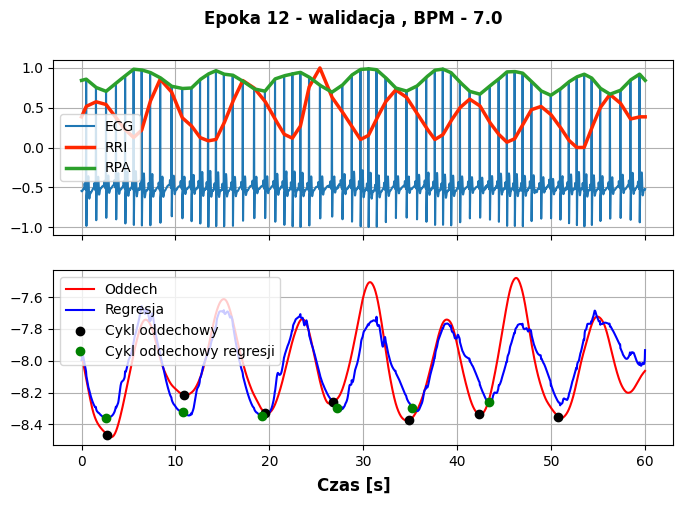

Epoch [12/30], LR: [0.001]
Avg train loss: 0.015525  |  Avg validation loss: 0.014351
Train NCC: 0.9015 | Val NCC: 0.9145



 98%|█████████▊| 57/58 [00:07<00:00,  7.40it/s]

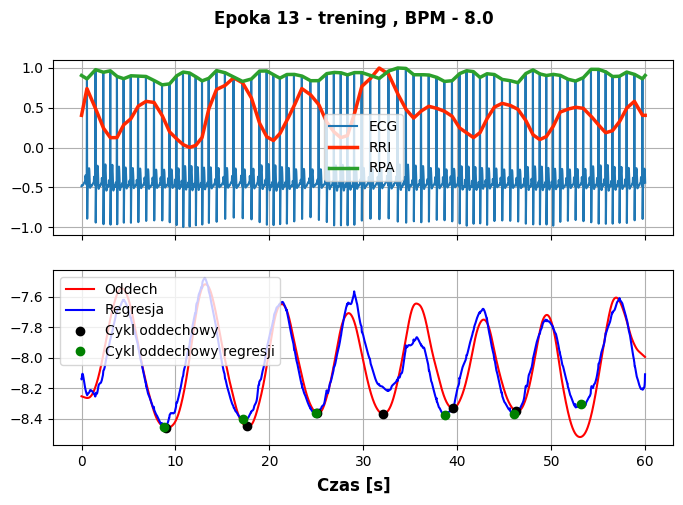

100%|██████████| 58/58 [00:08<00:00,  7.13it/s]


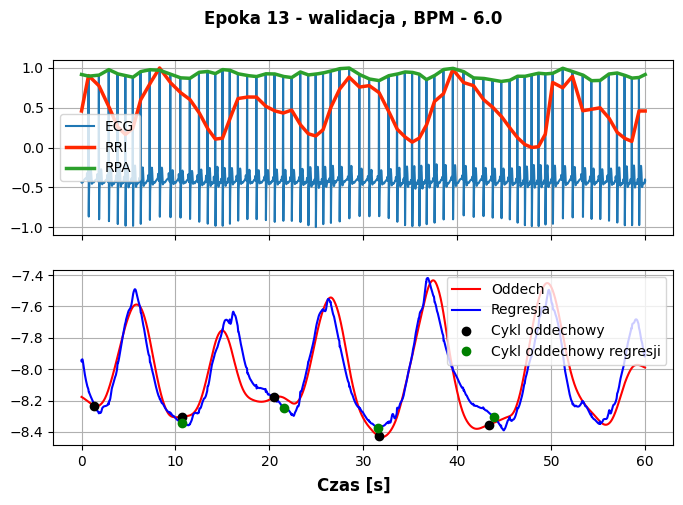

Epoch [13/30], LR: [0.001]
Avg train loss: 0.015275  |  Avg validation loss: 0.014377
Train NCC: 0.9044 | Val NCC: 0.9141



 98%|█████████▊| 57/58 [00:07<00:00,  7.42it/s]

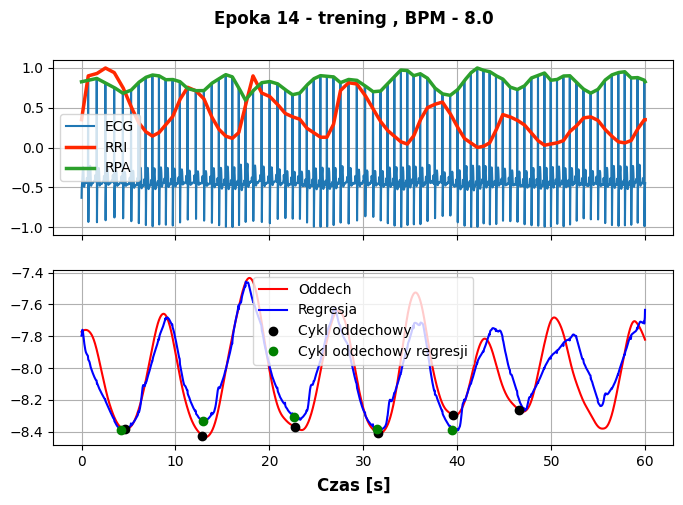

100%|██████████| 58/58 [00:08<00:00,  7.07it/s]


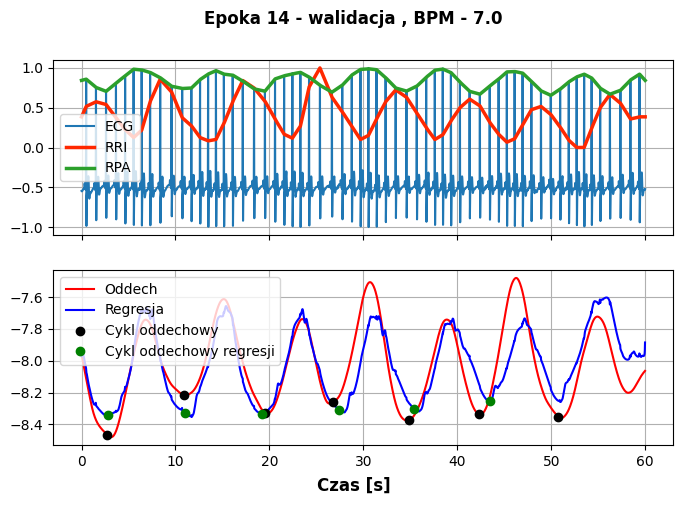

Epoch [14/30], LR: [0.001]
Avg train loss: 0.015943  |  Avg validation loss: 0.015317
Train NCC: 0.8991 | Val NCC: 0.9050



 98%|█████████▊| 57/58 [00:07<00:00,  7.66it/s]

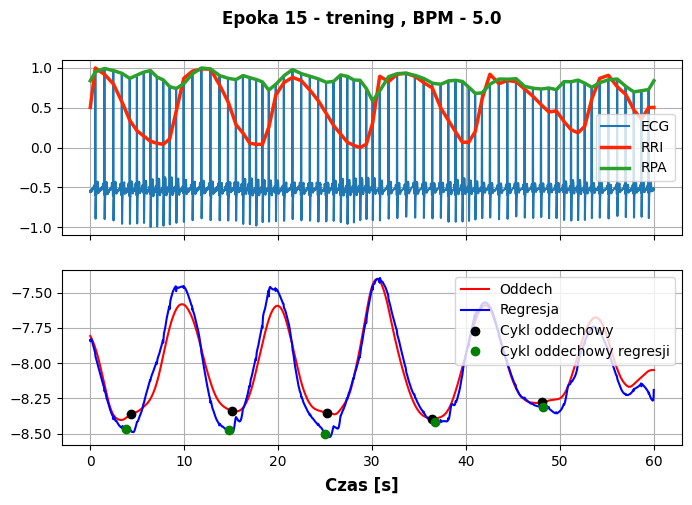

100%|██████████| 58/58 [00:08<00:00,  7.13it/s]


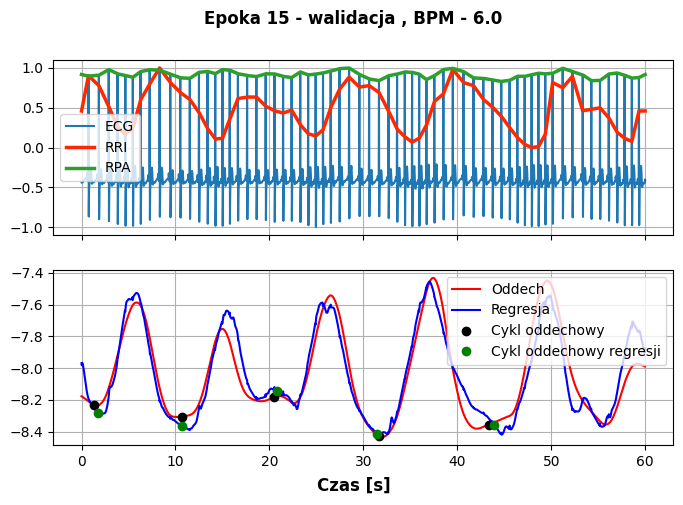

Epoch [15/30], LR: [0.001]
Avg train loss: 0.015457  |  Avg validation loss: 0.014281
Train NCC: 0.9024 | Val NCC: 0.9141



 98%|█████████▊| 57/58 [00:07<00:00,  7.58it/s]

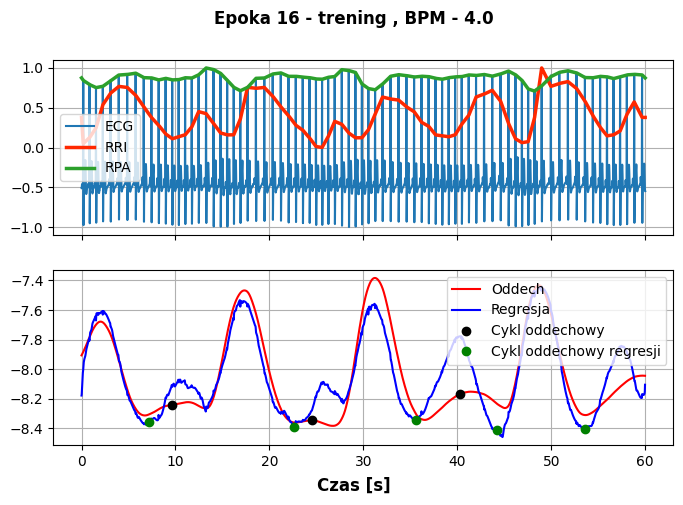

100%|██████████| 58/58 [00:08<00:00,  7.13it/s]


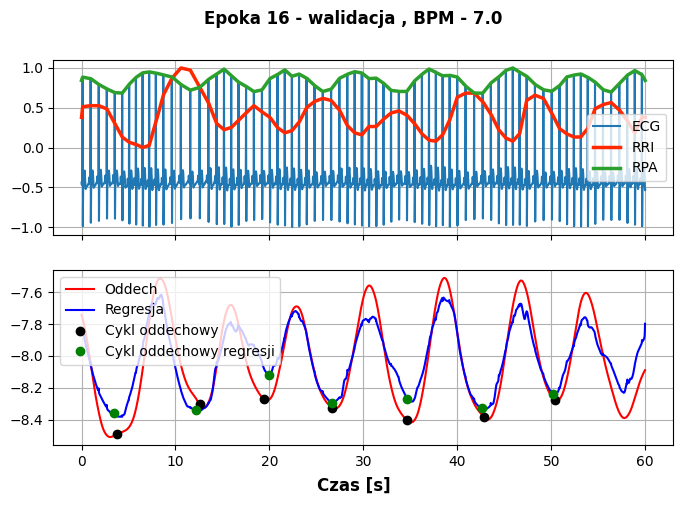

Epoch [16/30], LR: [0.001]
Avg train loss: 0.014990  |  Avg validation loss: 0.013885
Train NCC: 0.9067 | Val NCC: 0.9189



 98%|█████████▊| 57/58 [00:07<00:00,  7.55it/s]

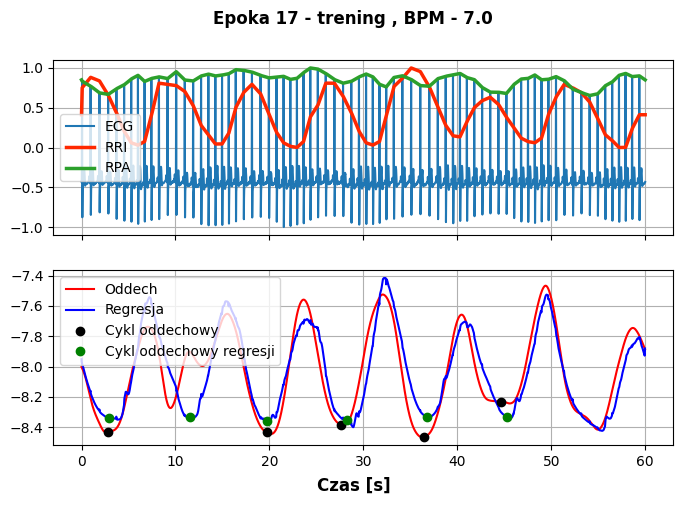

100%|██████████| 58/58 [00:08<00:00,  7.07it/s]


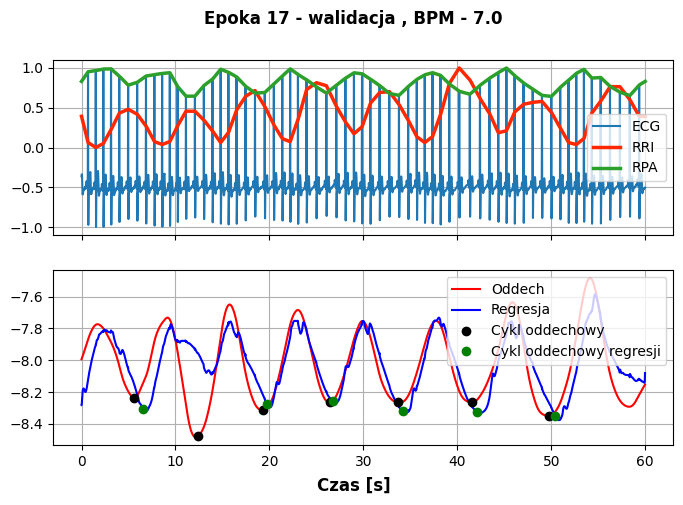

Epoch [17/30], LR: [0.001]
Avg train loss: 0.014608  |  Avg validation loss: 0.013794
Train NCC: 0.9097 | Val NCC: 0.9199



 98%|█████████▊| 57/58 [00:07<00:00,  7.53it/s]

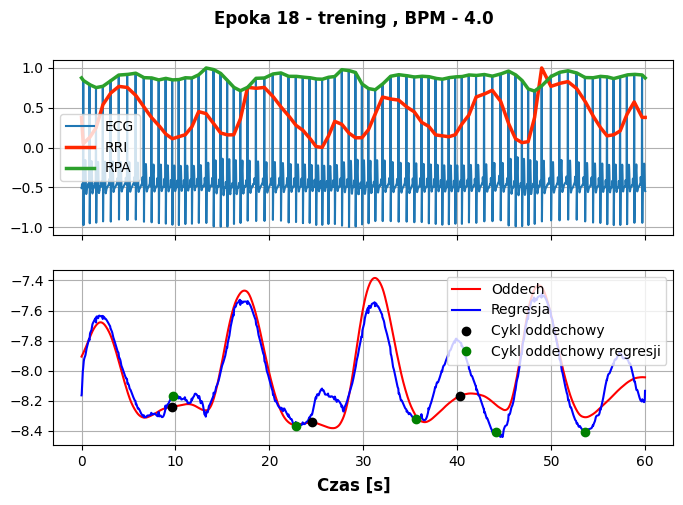

100%|██████████| 58/58 [00:08<00:00,  7.10it/s]


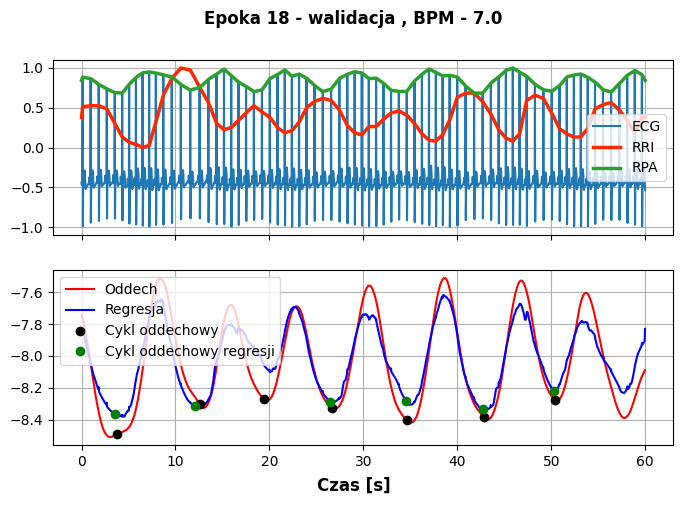

Epoch [18/30], LR: [0.001]
Avg train loss: 0.014443  |  Avg validation loss: 0.013221
Train NCC: 0.9116 | Val NCC: 0.9242



 98%|█████████▊| 57/58 [00:07<00:00,  7.43it/s]

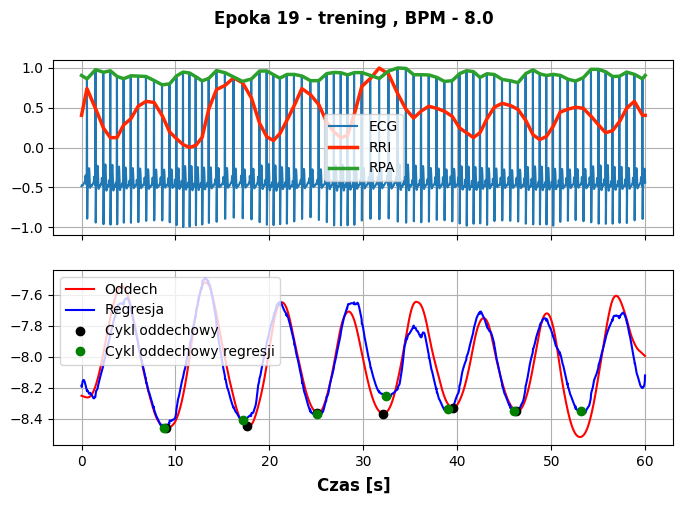

100%|██████████| 58/58 [00:08<00:00,  7.02it/s]


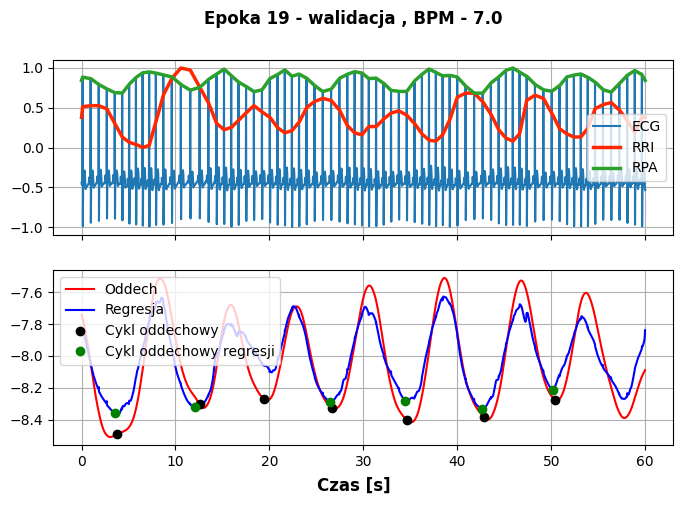

Epoch [19/30], LR: [0.001]
Avg train loss: 0.014041  |  Avg validation loss: 0.012875
Train NCC: 0.9150 | Val NCC: 0.9285



 98%|█████████▊| 57/58 [00:07<00:00,  7.52it/s]

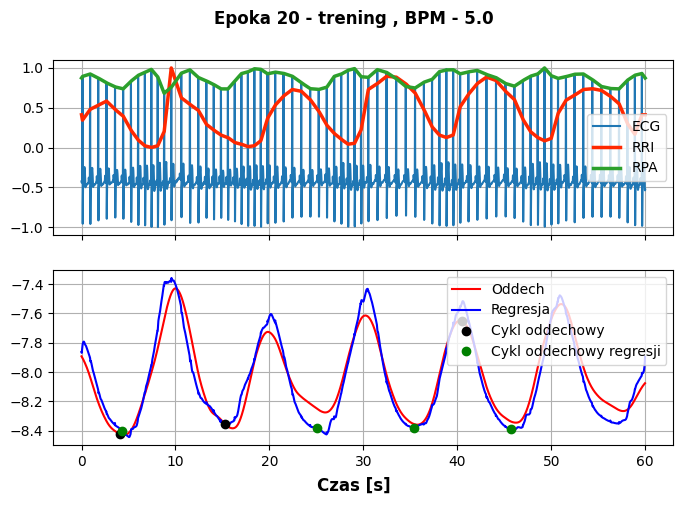

100%|██████████| 58/58 [00:08<00:00,  7.04it/s]


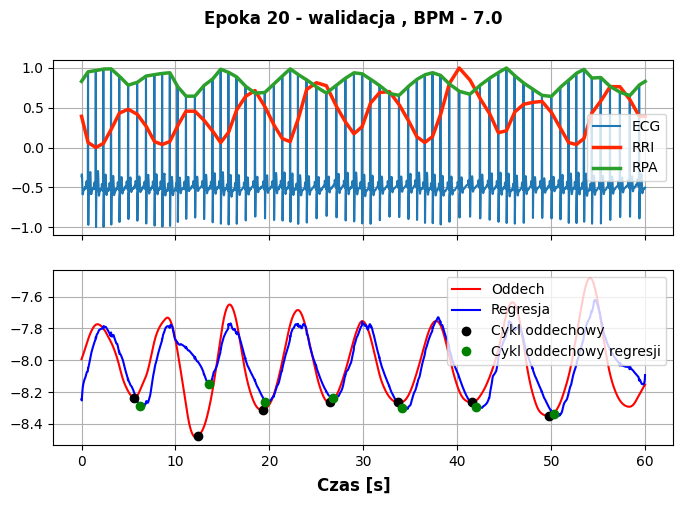

Epoch [20/30], LR: [0.001]
Avg train loss: 0.013735  |  Avg validation loss: 0.013050
Train NCC: 0.9180 | Val NCC: 0.9290



 98%|█████████▊| 57/58 [00:07<00:00,  7.49it/s]

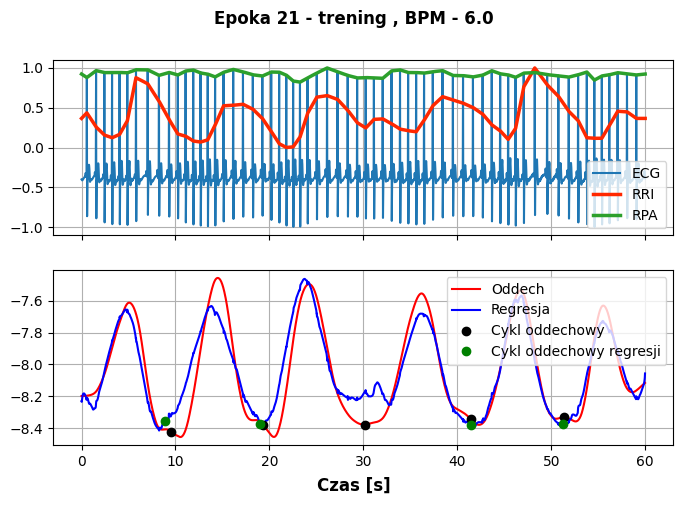

100%|██████████| 58/58 [00:08<00:00,  7.10it/s]


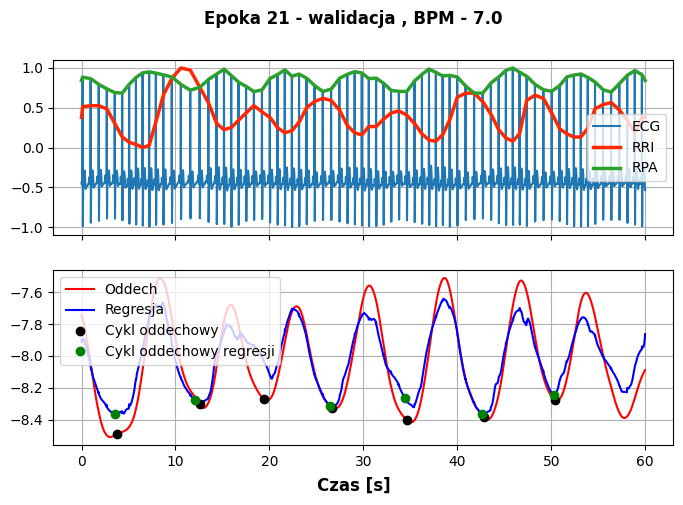

Epoch [21/30], LR: [0.001]
Avg train loss: 0.013328  |  Avg validation loss: 0.012707
Train NCC: 0.9220 | Val NCC: 0.9290



 98%|█████████▊| 57/58 [00:07<00:00,  7.51it/s]

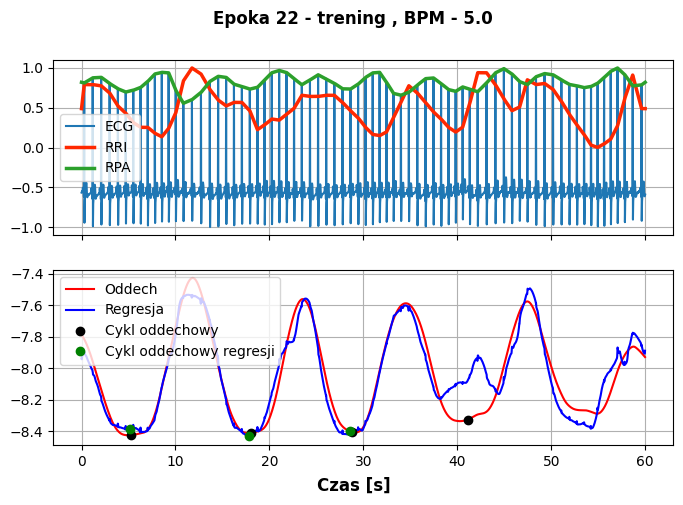

100%|██████████| 58/58 [00:08<00:00,  6.98it/s]


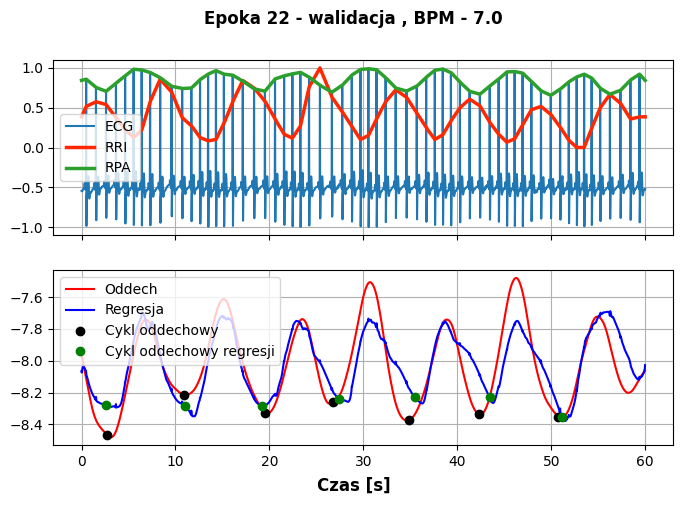

Epoch [22/30], LR: [0.001]
Avg train loss: 0.013232  |  Avg validation loss: 0.014386
Train NCC: 0.9229 | Val NCC: 0.9100



 98%|█████████▊| 57/58 [00:07<00:00,  7.44it/s]

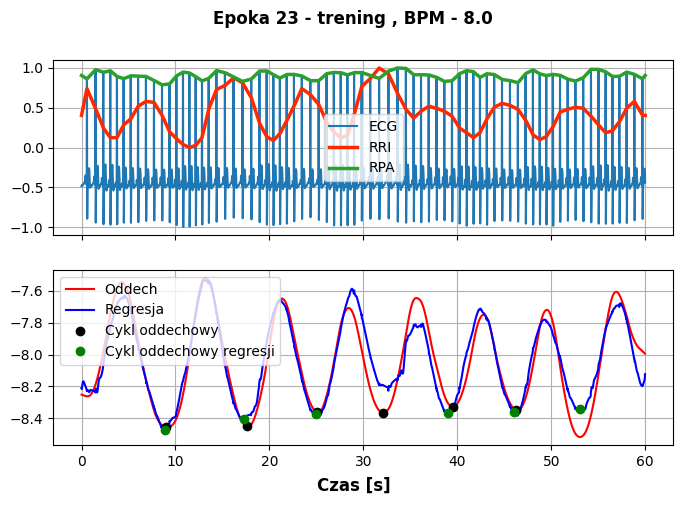

100%|██████████| 58/58 [00:08<00:00,  7.02it/s]


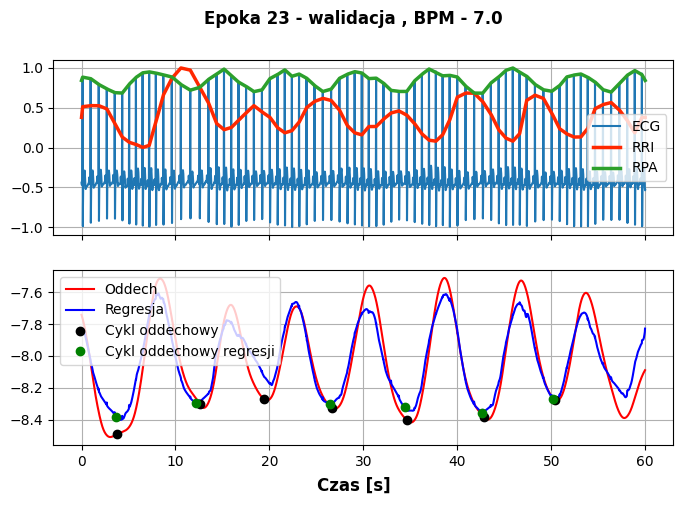

Epoch [23/30], LR: [0.001]
Avg train loss: 0.013393  |  Avg validation loss: 0.012348
Train NCC: 0.9227 | Val NCC: 0.9334



 98%|█████████▊| 57/58 [00:07<00:00,  7.52it/s]

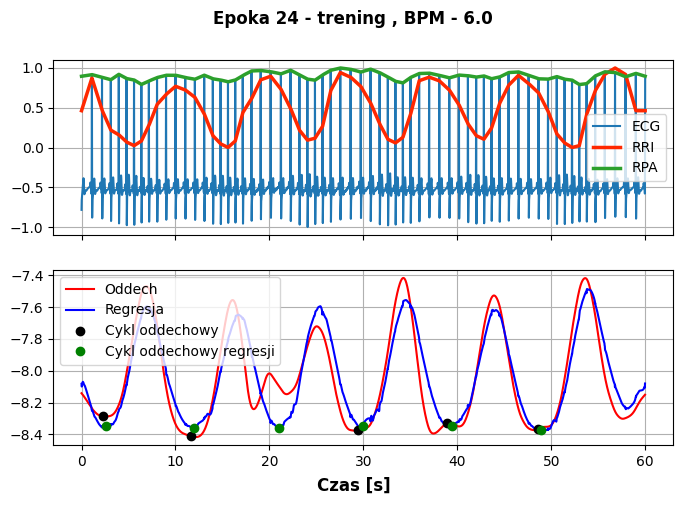

100%|██████████| 58/58 [00:08<00:00,  7.04it/s]


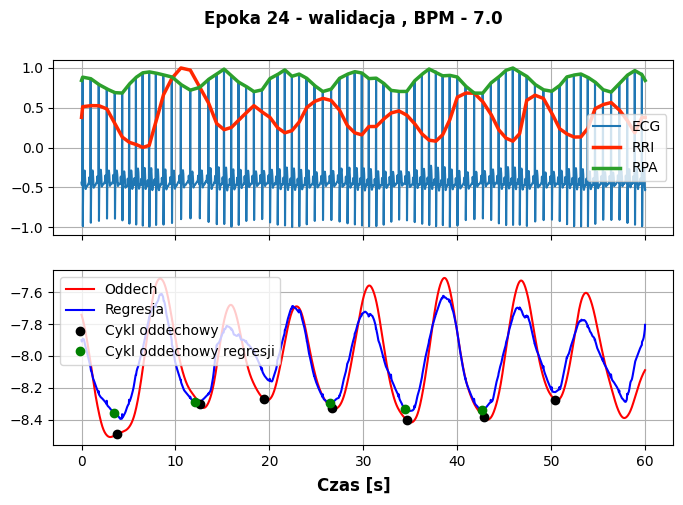

Epoch [24/30], LR: [0.001]
Avg train loss: 0.012944  |  Avg validation loss: 0.011937
Train NCC: 0.9261 | Val NCC: 0.9363



 98%|█████████▊| 57/58 [00:07<00:00,  7.33it/s]

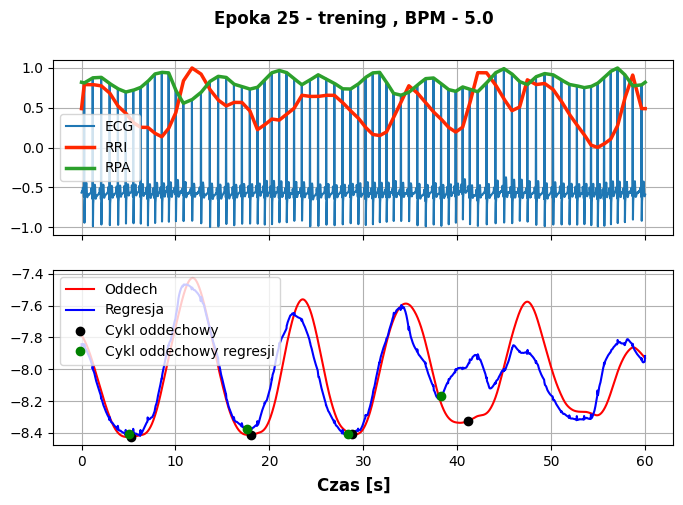

100%|██████████| 58/58 [00:08<00:00,  6.89it/s]


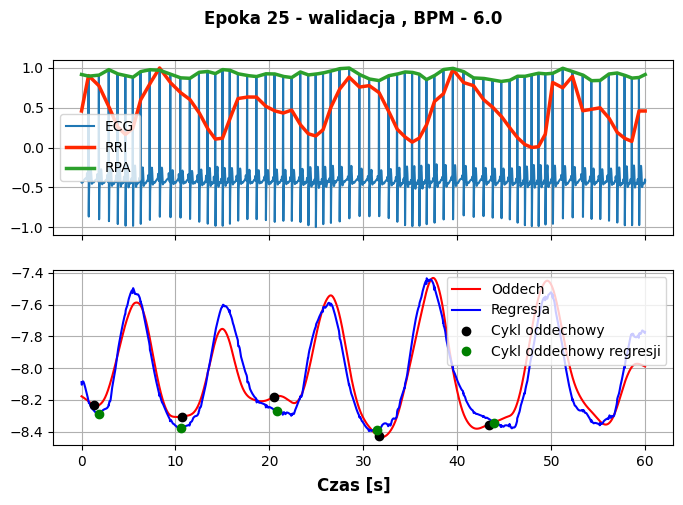

Epoch [25/30], LR: [0.0001]
Avg train loss: 0.012979  |  Avg validation loss: 0.012185
Train NCC: 0.9254 | Val NCC: 0.9340



 98%|█████████▊| 57/58 [00:07<00:00,  7.55it/s]

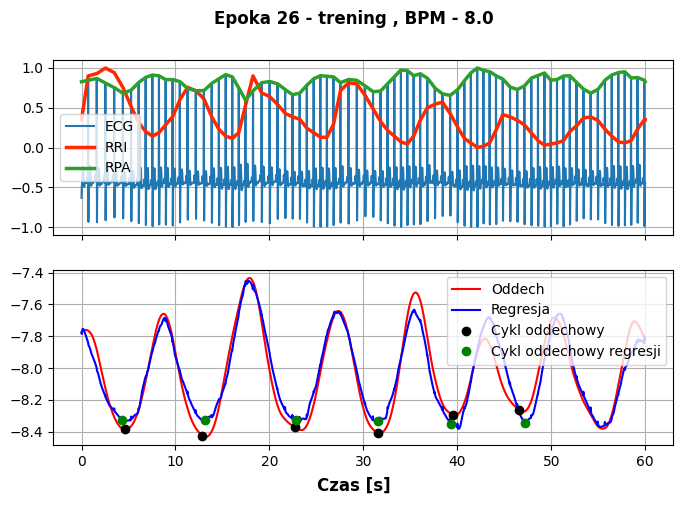

100%|██████████| 58/58 [00:08<00:00,  7.01it/s]


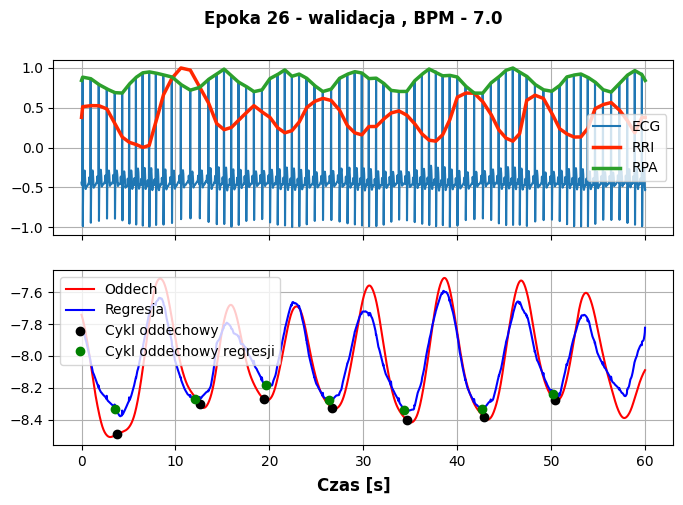

Epoch [26/30], LR: [0.0001]
Avg train loss: 0.011787  |  Avg validation loss: 0.011323
Train NCC: 0.9352 | Val NCC: 0.9414



 98%|█████████▊| 57/58 [00:07<00:00,  7.43it/s]

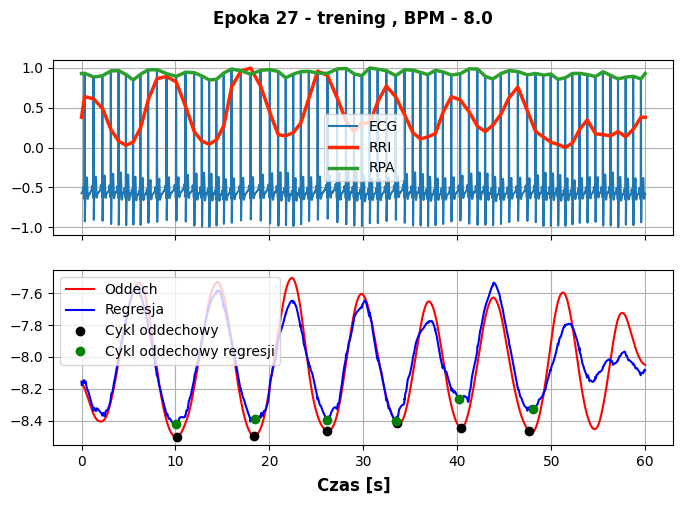

100%|██████████| 58/58 [00:08<00:00,  7.03it/s]


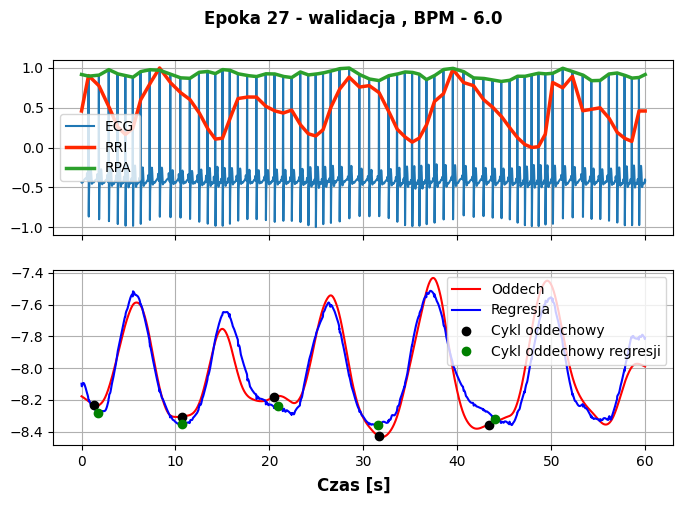

Epoch [27/30], LR: [0.0001]
Avg train loss: 0.011527  |  Avg validation loss: 0.011237
Train NCC: 0.9369 | Val NCC: 0.9425



 98%|█████████▊| 57/58 [00:07<00:00,  7.40it/s]

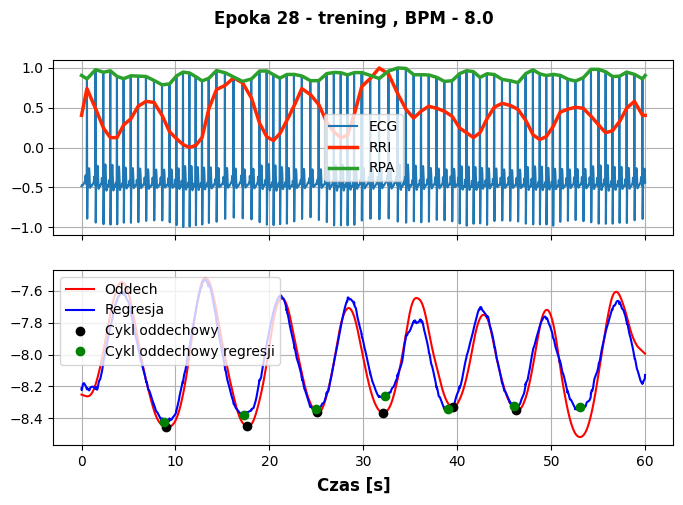

100%|██████████| 58/58 [00:08<00:00,  6.73it/s]


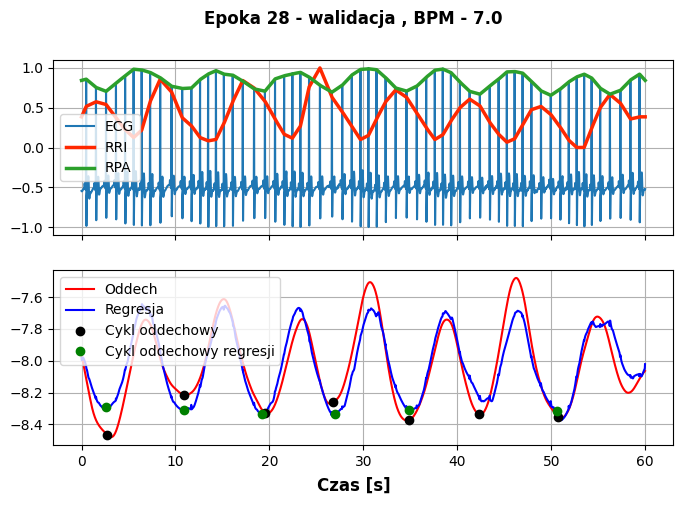

Epoch [28/30], LR: [0.0001]
Avg train loss: 0.011435  |  Avg validation loss: 0.011170
Train NCC: 0.9377 | Val NCC: 0.9428



 98%|█████████▊| 57/58 [00:07<00:00,  7.43it/s]

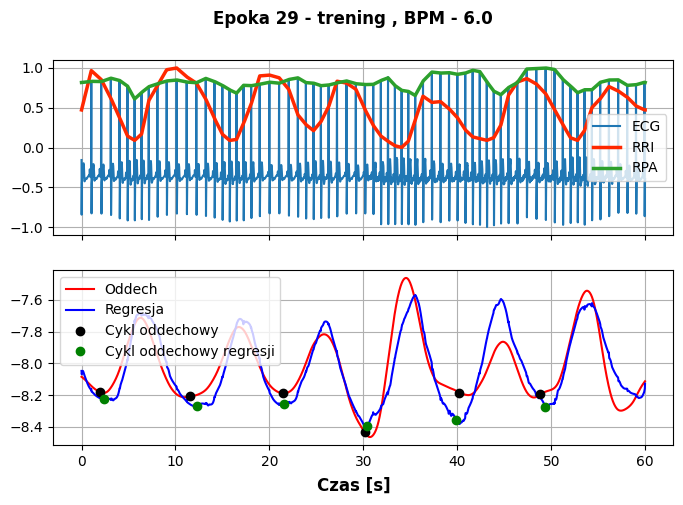

100%|██████████| 58/58 [00:08<00:00,  6.94it/s]


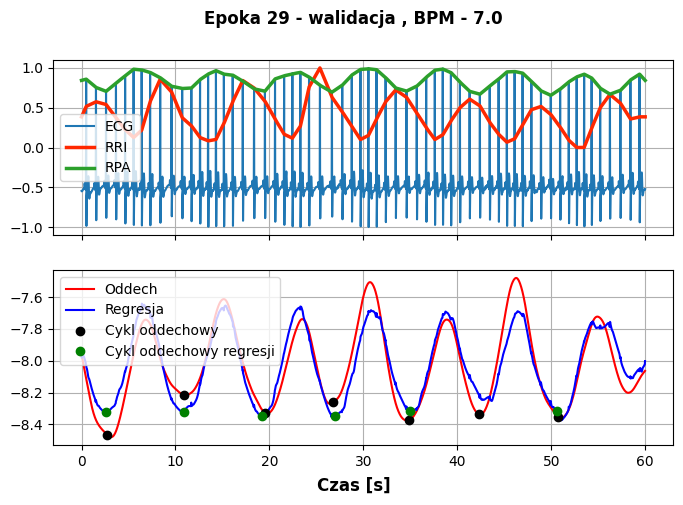

Epoch [29/30], LR: [0.0001]
Avg train loss: 0.011500  |  Avg validation loss: 0.011197
Train NCC: 0.9370 | Val NCC: 0.9419



 98%|█████████▊| 57/58 [00:07<00:00,  7.29it/s]

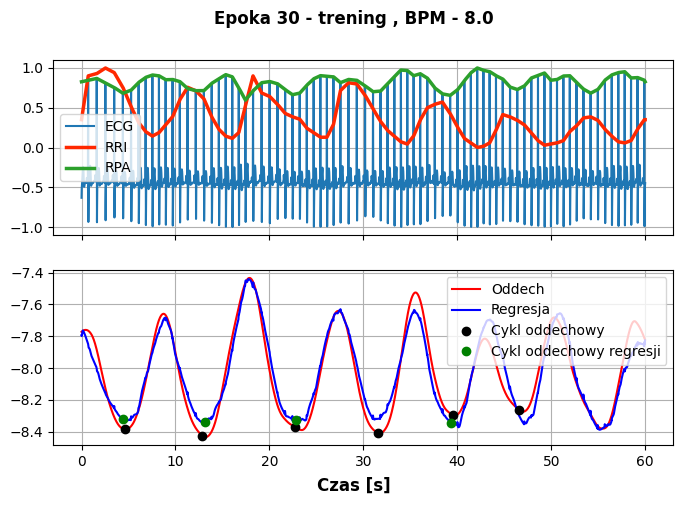

100%|██████████| 58/58 [00:08<00:00,  6.65it/s]


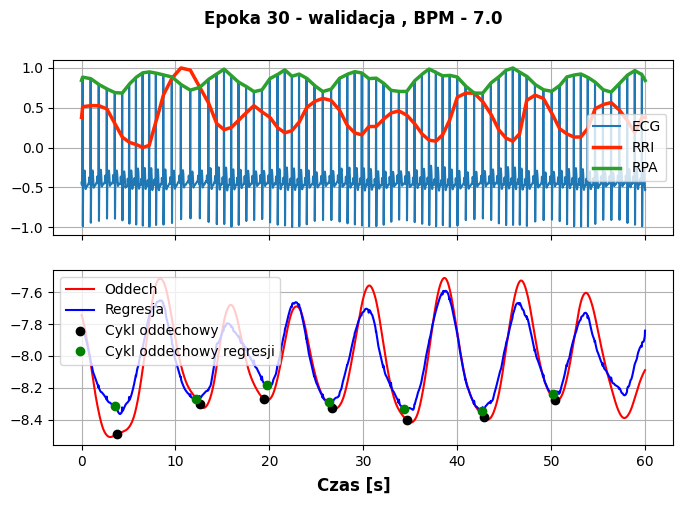

Epoch [30/30], LR: [0.0001]
Avg train loss: 0.011372  |  Avg validation loss: 0.011108
Train NCC: 0.9380 | Val NCC: 0.9436



In [21]:
model, metrics = train(model, train_loader, val_loader, learning_rate=0.001, epochs=30, alfa=0.9)

In [22]:
with open("./checkpoints/resp/metrics_3_channels_ecg_full_dataset.pkl", "wb") as f:
    pickle.dump(metrics, f)

torch.save(model.state_dict(), "./checkpoints/resp/regession_model_3_channels_ecg_full_dataset.pt")

In [23]:
def plot_resp_metrics(metrics):
    train_loss = metrics["train"]["loss"]["sum"]
    train_l1 = metrics["train"]["loss"]["L1"]
    train_kldiv = metrics["train"]["loss"]["KLDivLoss"]
    train_ncc = metrics["train"]["NCC"]

    val_loss = metrics["val"]["loss"]["sum"]
    val_l1 = metrics["val"]["loss"]["L1"]
    val_kldiv =metrics["val"]["loss"]["KLDivLoss"]
    val_ncc = metrics["val"]["NCC"]

    epochs = [x for x in range(len(train_loss))]

    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)

    ax = axs[0][0]
    ax.plot(epochs, train_loss, 'k-')
    ax.plot(epochs, val_loss, 'r-')
    ax.set_title("Funkcja straty", fontsize=12, fontweight="semibold")
    ax.grid()
    ax.legend(["Trening", "Walidacja"])

    ax = axs[1][0]
    ax.plot(epochs, train_l1, 'k-')
    ax.plot(epochs, val_l1, 'r-')
    ax.set_title("MAE", fontsize=12, fontweight="semibold")
    ax.grid()
    ax.legend(["Trening", "Walidacja"])
    ax.set_xlabel("Epoka", fontsize=12, fontweight="semibold")

    ax = axs[0][1]
    ax.plot(epochs, train_kldiv, 'k-')
    ax.plot(epochs, val_kldiv, 'r-')
    ax.set_title("Dywergencja KL", fontsize=12, fontweight="semibold")
    ax.grid()
    ax.legend(["Trening", "Walidacja"])

    ax = axs[1][1]
    ax.plot(epochs, train_ncc, 'k-')
    ax.plot(epochs, val_ncc, 'r-')
    ax.set_title("Miara NCC", fontsize=12, fontweight="semibold")
    ax.grid()
    ax.legend(["Trening", "Walidacja"])
    ax.set_xlabel("Epoka", fontsize=12, fontweight="semibold")

    fig.set_size_inches(8, 6)

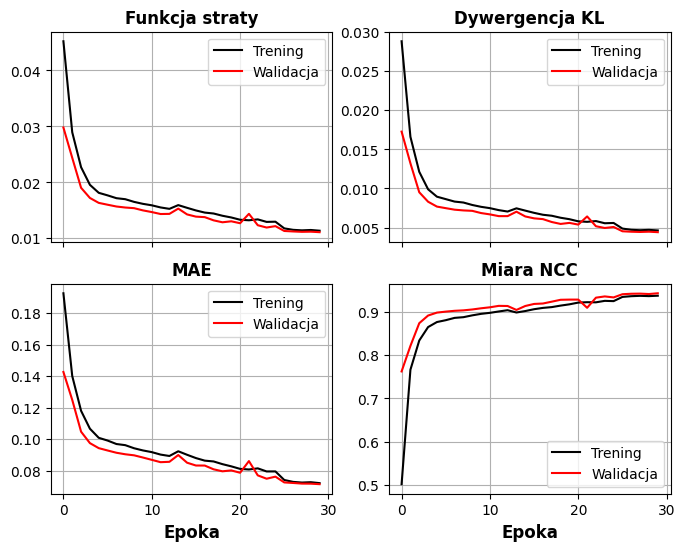

In [24]:
plot_resp_metrics(metrics)

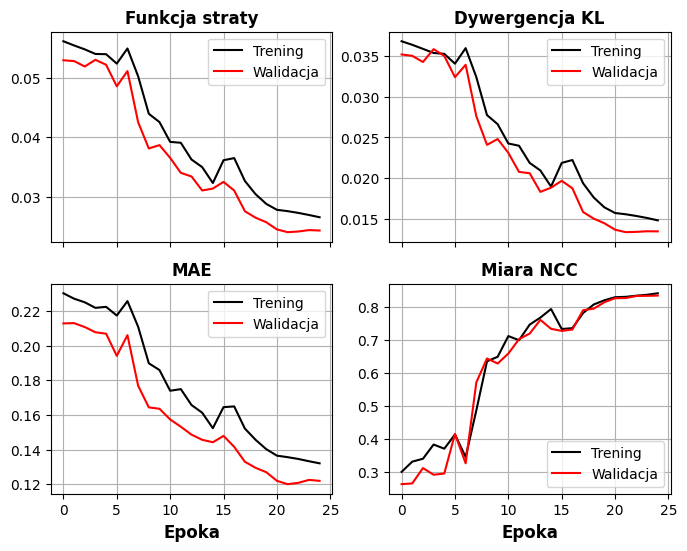

In [11]:
with open("./checkpoints/resp/metrics_3_channels_ecg_full_dataset.pkl", "rb") as f:
   metrics = pickle.load(f)

### Test

In [19]:
model = RespToECG(input_size=3)
model.load_state_dict(torch.load("./checkpoints/resp/regession_model_3_channels_ecg_full_dataset.pt", weights_only=True))
model.eval()

e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RespToECG(
  (lstm_1): LSTM(3, 64, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dense_1): Linear(in_features=128, out_features=64, bias=True)
  (interpolation_layer): InterpolateLayer()
  (lstm_2): LSTM(64, 64, batch_first=True, bidirectional=True)
  (dense_2): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
# test_2//large_respiration_rate - test files with larger respiration rate
# test_2//small_respiration_rate - test files with smaller respiration rate

#test_path = os.path.join(root_path, "test")
#test_path = os.path.join(root_path, "test_2", "large_respiration_rate")
#test_path = os.path.join(root_path, "test_2", "small_respiration_rate")
test_path = os.path.join(root_path, "test_3")

In [10]:
test_files = [x for x in os.listdir(test_path) if not os.path.isdir(root_path + "//" + x)]

ecgs = [os.path.join(test_path, x) for x in test_files[0::4]]
cycles =  [os.path.join(test_path, x) for x in test_files[1::4]]
resps =  [os.path.join(test_path, x) for x in test_files[2::4]]
annotations =  [os.path.join(test_path, x) for x in test_files[3::4]]

assert len(test_files) == len(ecgs) + len(resps) + len(annotations) + len(cycles)
assert (len(ecgs) + len(resps) + len(annotations) + len(cycles)) % 4 == 0

In [25]:
x_test, y_test = prepare_x_y_windows(window_in_seconds=235, windows_overlap_factor=0.9)           # normal resp - windows_overlap_factor=0.85
x_test, y_test = filter_windows(x_test, y_test, window_in_seconds=235, resp_peaks=16, mode="le")    # normal resp - resp_peaks=9, mode="le"

x_test = add_new_ecg_channels(x_test, detector="neurokit")

In [57]:
# did not save the settings for creating normal breath windows, so reverse-engineer that

dir = "E:\\ml-data\\masters-thesis\\myDataset\\resp_prediction\\normal_breathing"
files = [x for x in os.listdir(dir) if x.endswith("targets.npy")]

y_test = []

for file in files:
    array = np.load(os.path.join(dir, file))
    y_test.append(array)

y_test = np.array(y_test).squeeze()

resp_peaks = y_test[:,:,1]

resp_peaks_sum = np.sum(resp_peaks, axis=-1)
print("Resp peaks per recording: ", resp_peaks_sum / (resp_peaks.shape[1] / 50) * 60)

Resp peaks per recording:  [8.         8.33333333 8.66666667 8.66666667 8.66666667 8.66666667
 9.         9.         8.66666667 8.66666667 9.         8.33333333
 9.         8.33333333 7.         7.33333333 7.33333333 7.66666667
 8.         8.         8.33333333]


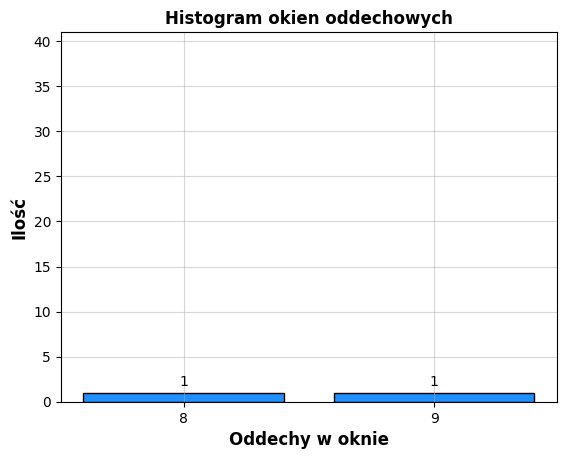

In [26]:
normal_breathing = breath_histogram(y_test[:,:,1])
#fast_breathig = breath_histogram(y_test[:,:,1])
#slow_breathing = breath_histogram(y_test[:,:,1])


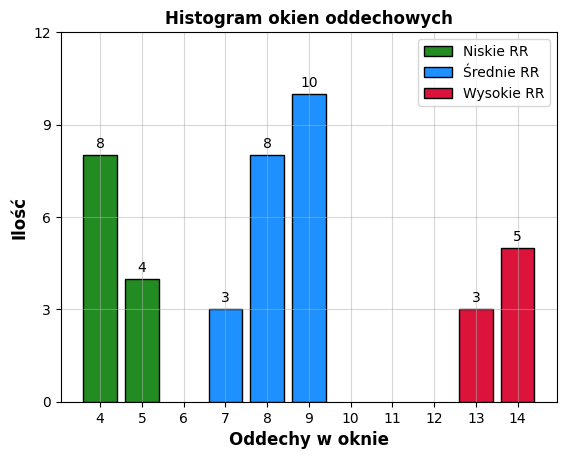

In [102]:
normal_breathing_keys = normal_breathing.keys()
normal_breathing_values = normal_breathing.values()

fast_breathing_keys = fast_breathig.keys()
fast_breathing_values = fast_breathig.values()

slow_breathing_keys = slow_breathing.keys()
slow_breathing_values = slow_breathing.values()

_, ax = plt.subplots()

ax.grid(alpha=0.5)

bars_1 = ax.bar(slow_breathing_keys, slow_breathing_values, color='forestgreen', edgecolor='black')
ax.bar_label(bars_1, padding=3, fontsize=10)
bars_2 = ax.bar(normal_breathing_keys, normal_breathing_values, color='dodgerblue', edgecolor='black')
ax.bar_label(bars_2, padding=3, fontsize=10)
bars_3 = ax.bar(fast_breathing_keys, fast_breathing_values, color='crimson', edgecolor='black')
ax.bar_label(bars_3, padding=3, fontsize=10)

ax.set_xticks([x for x in range(4, 15)])
ax.set_yticks([x for x in range(0,13,3)])
ax.set_ylim(0,12)

#ax.bar_label(bars)

plt.legend(["Niskie RR", "Średnie RR", "Wysokie RR"])
plt.xlabel('Oddechy w oknie', fontweight="semibold", fontsize=12)
plt.ylabel('Ilość', fontweight="semibold", fontsize=12)
plt.title('Histogram okien oddechowych', fontweight="semibold")

# Display the plot
plt.show()

In [27]:
test_dataset = DeviceDataset(data=x_test, labels=y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [16]:
# save_path = "E:\\ml-data\\masters-thesis\\myDataset\\resp_prediction\\normal_breathing"

def test(model, test_loader, alfa=0.5):
    model.eval()  # Set the model to evaluation mode
    criterion_1 = torch.nn.L1Loss() # WeightedL1Loss()
    criterion_2 = torch.nn.KLDivLoss(reduction="batchmean", log_target=True) # WeightedKLDivLoss(loss_weights=loss_function_weights, reduction="batchmean", log_target=True)
    metric_criterion = NCC()

    epoch_test_loss = 0.0
    epoch_kldiv_loss = 0.0
    epoch_l1_loss = 0.0
    metric_value = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.unsqueeze(-1)
            outputs = outputs.permute((0,2,1))
            outputs = F.conv1d(outputs, weight=smoothening_kernel)
            outputs = F.pad(outputs, (padding_amount, padding_amount), mode='replicate')
            outputs = outputs.permute((0,2,1))
            outputs = outputs.squeeze(-1)

            # Compute the loss
            loss_1 = criterion_1(outputs, targets[:,:,0]) #, targets[:,:,1])
            loss_2 = criterion_2(outputs, targets[:,:,0]) #, targets[:,:,1])

            metric_value += metric_criterion(outputs, targets[:,:,0], targets[:,:,1])
            loss = (1-alfa) * loss_1 + alfa * loss_2


            epoch_l1_loss += loss_1.item()
            epoch_kldiv_loss += loss_2.item()
            epoch_test_loss += loss.item()

            # if epoch > 7:
            #     a, b, c = calculate_peak_misalignment(targets[:,:,0], outputs)
            #     peak_misalignment += a
            #     total_target_resp_peaks += b
            #     total_pred_resp_peaks += c
            # d, e = calculate_cycle_time_deviation(targets, outputs, 50)
            #     cycle_time_deviation += d
            #     matching_cycles += e

            plot_result(inputs, targets, outputs, title=f"Example {batch_idx + 1}")

            targets = targets.cpu().numpy()
            prediction = outputs.cpu().numpy()
            inputs = inputs.cpu().numpy()

            # Saving prediction for manual evaluiation
            #if save_path != "":
                #target_resp = invert_log_softmax(targets[:,:,0].flatten())
                #target_resp = norm_min_max(target_resp, -1, 1)

                #np.save(os.path.join(save_path, str(batch_idx) + "_inputs.npy"), inputs)
                #np.save(os.path.join(save_path, str(batch_idx) + "_targets.npy"), target_resp)
                #np.save(os.path.join(save_path, str(batch_idx) + "_prediction.npy"), prediction.flatten())

                #target_peaks_prob = targets[:,:,1].flatten()
                #target_cycles_prob = targets[:,:,2].flatten()

                #target_peaks = np.where(target_peaks_prob == 1)[0]
                #target_cycles = np.where(target_cycles_prob == 1)[0]

                #with open(os.path.join(save_path, str(batch_idx) + "_targets.peaks"), "wb") as f:
                #    pickle.dump(target_peaks.flatten(), f)
                #with open(os.path.join(save_path, str(batch_idx) + "_targets.cycles"), "wb") as f:
                #    pickle.dump(target_cycles.flatten(), f)
            
    print(
            f"Test loss: {epoch_test_loss / len(test_loader):<6.4f}\n"
            f"Test NCC: {metric_value / len(test_loader):<6.4f}"
        )

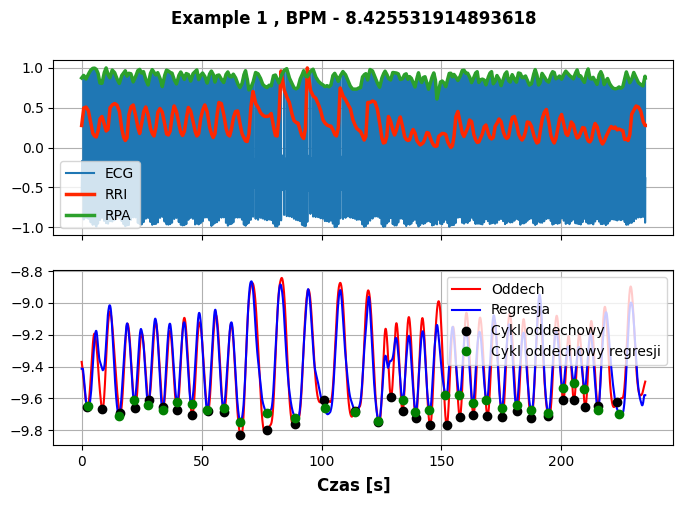

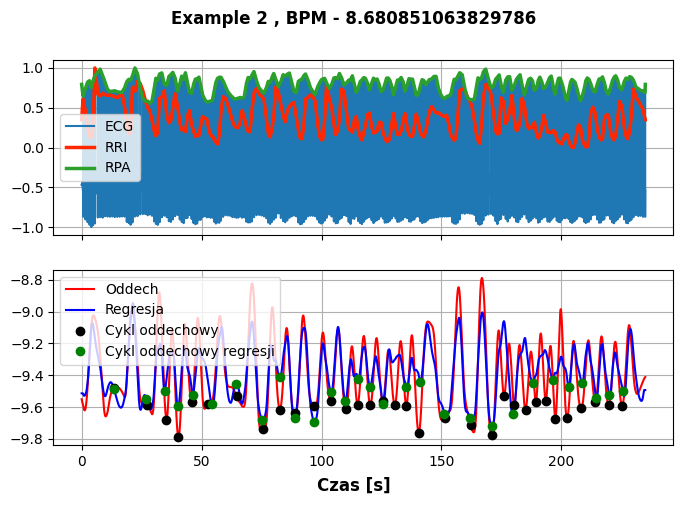

Test loss: 0.0068
Test NCC: 0.8821


In [28]:
test(model, test_loader, alfa=1)